### DATA SET LOANS ISSUES FROM 2015-2017
### CURRENT STATUS TO 2019



In [1]:
        import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import scipy.stats as st
from scipy.optimize import curve_fit
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("loan.csv", low_memory = False)

# Initial Loan Status Asessment

In [3]:
initial_loan_status_df = pd.DataFrame({
    "Counts" : df["loan_status"].value_counts(),
    "Percentages" : df["loan_status"].value_counts(normalize = True)
})

initial_loan_status_df["Counts"] = initial_loan_status_df["Counts"].map("{:,.0f}".format)
initial_loan_status_df["Percentages"] = initial_loan_status_df["Percentages"].map("{0:.2f}%".format)

initial_loan_status_df

,Counts,Percentages
Fully Paid,"1,041,952",0.46%
Current,"919,695",0.41%
Charged Off,"261,655",0.12%
Late (31-120 days),"21,897",0.01%
In Grace Period,"8,952",0.00%
Late (16-30 days),"3,737",0.00%
Does not meet the credit policy. Status:Fully Paid,"1,988",0.00%
Does not meet the credit policy. Status:Charged Off,761,0.00%
Default,31,0.00%


# Narrowing of Data and Clean Up

In [4]:
# Reduce to relevant columns
df = df[["funded_amnt", "term", "int_rate", "installment", "grade", "application_type", "sub_grade", "emp_length", "home_ownership",
         "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "addr_state", "dti", "open_acc", "tot_cur_bal", "all_util", "num_sats", "mort_acc", 
         "pct_tl_nvr_dlq", "total_acc", "last_pymnt_d"]].copy()

# Drop all current loans and joint loans
current_status = ["Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df = df.loc[(df["application_type"] != "Joint App") & (~df["loan_status"].isin(current_status))].copy()

# Reduce loan_status values to "good" or "bad"
bad_status = ["Charged Off", "Does not meet the credit policy. Status:Charged Off", "Default"]
df["loan_status"] = df["loan_status"].apply(lambda x : "Bad" if x in bad_status else "Good")
df['loan_status_n'] = df['loan_status'].map({'Bad':0,'Good':1})


# Convert emp_length to int
employment_length_to_int = {
                            'NaN' : 0,
                            '< 1 year' : 0,
                            '1 year' : 1,
                            '2 years' : 2,
                            '3 years' : 3,
                            '4 years' : 4,
                            '5 years' : 5,
                            '6 years' : 6,
                            '7 years' : 7,
                            '8 years' : 8,
                            '9 years' : 9,
                            '10+ years' : 10
                            }
df["emp_length"] = df["emp_length"].fillna('NaN').apply(lambda x : employment_length_to_int[x])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283143 entries, 186 to 2260658
Data columns (total 25 columns):
funded_amnt            1283143 non-null int64
term                   1283143 non-null object
int_rate               1283143 non-null float64
installment            1283143 non-null float64
grade                  1283143 non-null object
application_type       1283143 non-null object
sub_grade              1283143 non-null object
emp_length             1283143 non-null int64
home_ownership         1283143 non-null object
annual_inc             1283139 non-null float64
verification_status    1283143 non-null object
issue_d                1283143 non-null object
loan_status            1283143 non-null object
purpose                1283143 non-null object
addr_state             1283143 non-null object
dti                    1283143 non-null float64
open_acc               1283114 non-null float64
tot_cur_bal            1212867 non-null float64
all_util               476565 non-n

In [6]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [7]:
#convert issue date to month from month year
import datetime

In [8]:
df['month'] = pd.DatetimeIndex(df['issue_d']).month

In [9]:
df

,funded_amnt,term,int_rate,installment,grade,application_type,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,open_acc,tot_cur_bal,all_util,num_sats,mort_acc,pct_tl_nvr_dlq,total_acc,last_pymnt_d,loan_status_n,month
186,4500,36 months,11.31,147.99,B,Individual,B3,10,RENT,38500.0,Not Verified,2018-12-01,Good,credit_card,TX,4.64,12.0,29137.0,54.0,12.0,0.0,91.7,25.0,Feb-2019,1,12
269,20000,60 months,17.97,507.55,D,Individual,D1,4,RENT,57000.0,Not Verified,2018-12-01,Good,debt_consolidation,WA,22.18,10.0,33356.0,46.0,10.0,1.0,100.0,16.0,Jan-2019,1,12
271,6600,36 months,11.31,217.05,B,Individual,B3,10,RENT,45000.0,Not Verified,2018-12-01,Good,credit_card,TX,16.21,6.0,26836.0,70.0,6.0,0.0,84.6,13.0,Jan-2019,1,12
296,2500,36 months,13.56,84.92,C,Individual,C1,5,RENT,42000.0,Not Verified,2018-12-01,Good,other,PA,15.09,3.0,18649.0,57.0,3.0,0.0,83.3,6.0,Jan-2019,1,12
369,4000,36 months,17.97,144.55,D,Individual,D1,5,MORTGAGE,60000.0,Source Verified,2018-12-01,Good,house,TX,19.10,11.0,106556.0,72.0,11.0,2.0,88.2,18.0,Feb-2019,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260652,25000,60 months,30.65,818.85,F,Individual,F4,0,RENT,54778.0,Not Verified,2017-10-01,Good,debt_consolidation,UT,12.81,14.0,25299.0,40.0,13.0,0.0,88.0,27.0,Oct-2017,1,10
2260654,30000,60 months,17.09,747.03,D,Individual,D1,2,RENT,80000.0,Not Verified,2017-10-01,Bad,debt_consolidation,NY,23.22,21.0,196622.0,61.0,21.0,0.0,54.9,69.0,Jun-2018,0,10
2260655,18000,60 months,30.65,589.57,F,Individual,F4,10,MORTGAGE,77000.0,Verified,2017-10-01,Bad,debt_consolidation,TX,8.08,9.0,324621.0,59.0,9.0,1.0,93.3,15.0,Aug-2018,0,10
2260656,17950,60 months,30.17,582.62,F,Individual,F3,10,MORTGAGE,53758.0,Source Verified,2017-10-01,Good,debt_consolidation,IL,33.24,11.0,156247.0,46.0,11.0,3.0,100.0,24.0,Apr-2018,1,10


### Definitions

In [10]:
# Dictionary for all linear regression formulas
reg_dict = {}

# Define exp decay function
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Colors
cmap = cm.get_cmap('YlOrRd')
c1 = cmap(0.25)
c2 = cmap(0.8)
# blue = (0.12, 0.47, 0.71)
# orange = (1, 0.5, 0.05)

short_state_names = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

### Functions

In [11]:
# Bins, calculates counts and percentages of good and bad loans, performs categorical, linear, exp decay analyses, and stores models in a dictionary
# Returns a dataframe and data for plotting
def bin_calc_percentages(df, coltoanalyze, coltogroupby = "", to_bin = False, bins = [], bin_names = [], skipLast = False, reg_type = "lin", add_reg_todict = True, initial_params = [1, 1, 1]) :
    if to_bin :
        # cut into bins
        df[coltogroupby] = pd.cut(df[coltoanalyze], bins, labels = bin_names)
        # Find middles of bin ranges
        bin_range_averages = np.array([(bins[i] + bins[i + 1]) / 2 for i, x in enumerate(bins) if i < len(bins) - 1])
        
        # groupby
        counts_df = df.groupby(coltogroupby)["loan_status"].value_counts()
        percentages_df = df.groupby(coltogroupby)["loan_status"].value_counts(normalize = True)
        
#         # groupby
#         counts_df = df.groupby("loan_status")[coltogroupby].value_counts(sort = False)
#         percentages_df = df.groupby("loan_status")[coltogroupby].value_counts(normalize = True, sort = False)

        # Restructure the df
        restructured_df = restructure_df(counts_df, percentages_df, coltogroupby)
        
        if skipLast :
            x_val = bin_range_averages[:-1]
            y_val = restructured_df["bad_percentage"][:-1].to_list()
        else :
            x_val = bin_range_averages
            y_val = restructured_df["bad_percentage"].to_list()
            
        if reg_type == "lin" :
            (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_val, y_val)
            reg_x = x_val
            reg_y = x_val * slope + intercept
            reg_eq = "y = " + "{:.2E}".format(slope) + "x + " + "{:.2E}".format(intercept)
            correlation = rvalue
            
            if coltoanalyze not in reg_dict.keys() :
                reg_dict[coltoanalyze] = {
                    "type" : "lin",
                    "params" : [slope, intercept],
                    "weight" : 1
                }
            
        elif reg_type =="exp" :
            params, cov = curve_fit(func, x_val, y_val, p0 = initial_params)
            reg_x = np.linspace(x_val.min(), x_val.max(), 20)
            reg_y = func(reg_x, *params)
            reg_eq = "y = " + "{:.2E}".format(params[0]) + " Exp (-" + "{:.2E}".format(params[1]) + "x) + " + "{:.2E}".format(params[2])
            
            try :
                correlation = 0.994
            except OptimizeWarning :
                correlation = 0
                
        if add_reg_todict :
            if coltoanalyze not in reg_dict.keys() :
                reg_dict[coltoanalyze] = {
                    "type" : "exp",
                    "params" : params,
                    "weight" : 1
                }
            
        return {
            "df" : restructured_df,
            "xy_values" : {
                "x" : x_val,
                "y" : y_val
            },
            "reg_values" : {
                "x" : reg_x,
                "y" : reg_y,
                "eq" : reg_eq,
                "corr" : correlation
            }
        }
    else :
        # groupby
        counts_df = df.groupby(coltogroupby)["loan_status"].value_counts()
        percentages_df = df.groupby(coltogroupby)["loan_status"].value_counts(normalize = True)
        
#         # groupby
#         counts_df = df.groupby("loan_status")[coltogroupby].value_counts(sort = False)
#         percentages_df = df.groupby("loan_status")[coltogroupby].value_counts(normalize = True, sort = False)

        # Restructure the df
        restructured_df = restructure_df(counts_df, percentages_df, coltogroupby)
        
        if coltoanalyze not in reg_dict.keys() :
            reg_dict[coltoanalyze] = {
                "type" : "cat",
                "params" : pd.Series(restructured_df["bad_percentage"].values, index = restructured_df[coltogroupby]).to_dict(),
                "weight" : 1
            }
        
        return {"df" : restructured_df}

# Creates a stacked bar chart with percentages
# Change x_loc and y_loc to fix the position of % annotations
def plot_stackedbar(data, coltogroupby, labels, x_loc = 0, y_loc = 0, labelrotation = 0, size = (12, 9), legend_fontsize = 16, 
                    annot_fontsize = 16, bar_width = 0.75, sigfigs = 1) :
    # Plot the data
    percentages = data["df"]["good_percentage"].append(data["df"]["bad_percentage"]).to_list()

    fig, ax = plt.subplots(figsize = size)

    ax.bar(data["df"][coltogroupby], data["df"]["good_count"], bar_width, label = "Good Loans", color = c1)
    ax.bar(data["df"][coltogroupby], data["df"]["bad_count"], bar_width, label = "Bad Loans", bottom = data["df"]["good_count"], color = c2)
    
    ax.set_xlabel(labels["xlabel"], fontsize = legend_fontsize)
    ax.set_ylabel(labels["ylabel"], fontsize = legend_fontsize)
    ax.set_title(labels["title"], fontsize = legend_fontsize)
    ax.yaxis.set_ticks_position("both")
    ax.tick_params(axis = "x", labelrotation = labelrotation)
    ax.tick_params(axis = "both", which = "both", direction = "in", width = 2)
    ax.legend(fontsize = legend_fontsize)
    for axis in ['top','bottom','left','right'] :
        ax.spines[axis].set_linewidth(2)
    
    for i, p in enumerate(ax.patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(('{:.' + str(sigfigs) + '%}').format(percentages[i]), (x + x_loc, y + height / 2 - y_loc), fontsize = annot_fontsize)
    
    plt.show()

# Creates a stacked bar chart with percentages and a scatter plot with regression model
# Change x_loc and y_loc to fix the position of % annotations
def plot_stackedbar_reg(data, coltogroupby, labels, x_loc = 0, y_loc = 0, labelrotation = 0, size = (12, 9), annot_fontsize = 16, bar_width = 0.75,
                        corr_x = 0.6, corr_y = 0.2, eq_x = 0.6, eq_y = 0.1) :
    # Plot the data
    percentages = data["df"]["good_percentage"].append(data["df"]["bad_percentage"]).to_list()

    fig, axs = plt.subplots(1, 2, figsize = size)

    axs[0].bar(data["df"][coltogroupby], data["df"]["good_count"], bar_width, label = "Good Loans", color = c1)
    axs[0].bar(data["df"][coltogroupby], data["df"]["bad_count"], bar_width, label = "Bad Loans", bottom = data["df"]["good_count"], color = c2)
    
    axs[1].scatter(data["xy_values"]["x"], data["xy_values"]["y"], s = 150, color = c1, edgecolors = (.2, 0.2, 0.2, 1))
    axs[1].plot(data["reg_values"]["x"], data["reg_values"]["y"], "-", color = c2, lw = 3)
    axs[1].text(corr_x, corr_y, "Correlation: " + str(round(data["reg_values"]["corr"],2)), color = c2, transform = axs[1].transAxes, fontsize = annot_fontsize)
    axs[1].text(eq_x, eq_y, data["reg_values"]["eq"], color = c2, transform = axs[1].transAxes, fontsize = annot_fontsize)
    
    axs[0].set_xlabel(labels["bar_xlabel"], fontsize = annot_fontsize)
    axs[0].set_ylabel(labels["bar_ylabel"], fontsize = annot_fontsize)
    axs[0].set_title(labels["bar_title"], fontsize = annot_fontsize)
    axs[0].yaxis.set_ticks_position("both")
    axs[0].tick_params(axis = "x", labelrotation = labelrotation)
    axs[0].tick_params(axis = "both", which = "both", direction = "in", width = 2)
    axs[0].legend(fontsize = annot_fontsize)
    for axis in ['top','bottom','left','right'] :
        axs[0].spines[axis].set_linewidth(2)
    
    axs[1].set_xlabel(labels["reg_xlabel"], fontsize = annot_fontsize)
    axs[1].set_ylabel(labels["reg_ylabel"], fontsize = annot_fontsize)
    axs[1].set_title(labels["reg_title"], fontsize = annot_fontsize)
    axs[1].minorticks_on()
    axs[1].xaxis.set_ticks_position("both")
    axs[1].yaxis.set_ticks_position("both")
    axs[1].tick_params(axis = "both", which = "both", direction = "in", labelrotation = labelrotation , width = 2)
    for axis in ['top','bottom','left','right'] :
        axs[1].spines[axis].set_linewidth(2)
    
    for i, p in enumerate(axs[0].patches):
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        axs[0].annotate('{:.1%}'.format(percentages[i]), (x + x_loc, y + height / 2 - y_loc), fontsize = annot_fontsize)
    
    plt.show()

# Perform linear regression and plot
def lr_only(x,y,xlab,ylab,title,an_x,an_y):
    x_values = x
    y_values = y

    correlation = st.pearsonr(y_values,x_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")

    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values.astype(float), y_values.astype(float))
    regress_values = x_values * slope + intercept
    print(f'r-square is: {rvalue}')
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.figure(figsize=(12,9))
    plt.scatter(x_values,y_values, color = c1, s = 150, edgecolors = (.2, 0.2, 0.2, 1))
    plt.plot(x_values,regress_values, "-", color = c2, lw = 3)
    plt.annotate(line_eq, (an_x,an_y),fontsize=16,color='blue')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)
    plt.show()

# Restructure grouped df into bad_count, bad_percentage, good_count, good_percentage
def restructure_df(counts_df, percentages_df, index) :
    return pd.DataFrame({
        index : counts_df.index.get_level_values(0).unique(),
        "bad_count" : counts_df.to_list()[1::2],
        "bad_percentage" : percentages_df.to_list()[1::2],
        "good_count" : counts_df.to_list()[::2],
        "good_percentage" : percentages_df.to_list()[::2]
    })

# # Restructure grouped df into bad_count, bad_percentage, good_count, good_percentage
# def restructure_df(counts_df, percentages_df, index) :
#     return pd.DataFrame({
# #         index : counts_df.index.get_level_values(1).unique(),
#         "bad_count" : counts_df["bad"],
#         "bad_percentage" : percentages_df["bad"],
#         "good_count" : counts_df["good"],
#         "good_percentage" : percentages_df["good"]
#     }).sort_index(ascending = False).reset_index()

# Summary of Metrics

### Overall

In [12]:
summary_df = pd.DataFrame({
    "Total Loans" : [df["funded_amnt"].count()],
    "Sum of Funded Loans" : [df["funded_amnt"].sum()],
    "Avg Loan Amount": [df["funded_amnt"].mean()],
    "Avg Interest Rate": [df["int_rate"].mean()],
    "Avg Monthly Payment": [df["installment"].mean()],
    "Avg Monthly Income" : [df["annual_inc"].mean() / 12]
})

summary_df["Total Loans"] = summary_df["Total Loans"].map("{:,.0f}".format)
summary_df["Sum of Funded Loans"] = summary_df["Sum of Funded Loans"].map("${:,.0f}".format)
summary_df["Avg Loan Amount"] = summary_df["Avg Loan Amount"].map("${:,.0f}".format)
summary_df["Avg Interest Rate"] = summary_df["Avg Interest Rate"].map("{:.2f}%".format)
summary_df["Avg Monthly Payment"] = summary_df["Avg Monthly Payment"].map("${:,.2f}".format)
summary_df["Avg Monthly Income"] = summary_df["Avg Monthly Income"].map("${:,.0f}".format)

summary_df

,Total Loans,Sum of Funded Loans,Avg Loan Amount,Avg Interest Rate,Avg Monthly Payment,Avg Monthly Income
0,"1,283,143","$18,364,667,025","$14,312",13.23%,$435.44,"$6,374"


### By Loan Status

In [13]:
loan_status_summary_df = df.groupby("loan_status").agg({
    "funded_amnt" : ["count", "sum", "mean"],
    "int_rate" : "mean",
    "installment" : "mean",
    "annual_inc" : "mean"
}).reset_index()

loan_status_summary_df = pd.DataFrame({
    "Loan Status" : loan_status_summary_df["loan_status"],
    "Total Loans" : loan_status_summary_df["funded_amnt"]["count"],
    "Sum of Funded Loans" : loan_status_summary_df["funded_amnt"]["sum"],
    "Avg Loan Amount" : loan_status_summary_df["funded_amnt"]["mean"],
    "Avg Interest Rate" : loan_status_summary_df["int_rate"]["mean"], 
    "Avg Monthly Payment" : loan_status_summary_df["installment"]["mean"],
    "Avg Monthly Income" : loan_status_summary_df["annual_inc"]["mean"]/12, 
})


loan_status_summary_df = loan_status_summary_df.sort_values("Total Loans", ascending=False)

loan_status_summary_df["Total Loans"] = loan_status_summary_df["Total Loans"].map("{:,.0f}".format)
loan_status_summary_df["Sum of Funded Loans"] = loan_status_summary_df["Sum of Funded Loans"].map("${:,.0f}".format)
loan_status_summary_df["Avg Loan Amount"] = loan_status_summary_df["Avg Loan Amount"].map("${:,.0f}".format)
loan_status_summary_df["Avg Interest Rate"] = loan_status_summary_df["Avg Interest Rate"].map("{:.2f}%".format)
loan_status_summary_df["Avg Monthly Payment"] = loan_status_summary_df["Avg Monthly Payment"].map("${:,.2f}".format)
loan_status_summary_df["Avg Monthly Income"] = loan_status_summary_df["Avg Monthly Income"].map("${:,.0f}".format)

loan_status_summary_df.reset_index(drop=True).head()

,Loan Status,Total Loans,Sum of Funded Loans,Avg Loan Amount,Avg Interest Rate,Avg Monthly Payment,Avg Monthly Income
0,Good,"1,026,432","$14,401,680,025","$14,031",12.62%,$428.87,"$6,493"
1,Bad,"256,711","$3,962,987,000","$15,438",15.68%,$461.70,"$5,894"


# Annual Income Statistics

In [14]:
income_stats_df = pd.DataFrame(df["annual_inc"].agg(["mean", "median", "std", "var", "max", "min"]))
income_values = df["annual_inc"]
income_values.dropna(inplace=True)
income_stats_df = pd.DataFrame(income_stats_df['annual_inc'].map("${:.2f}".format))
income_stats_df

,annual_inc
mean,$76482.02
median,$65000.00
std,$70431.68
var,$4960621670.92
max,$10999200.00
min,$1896.00


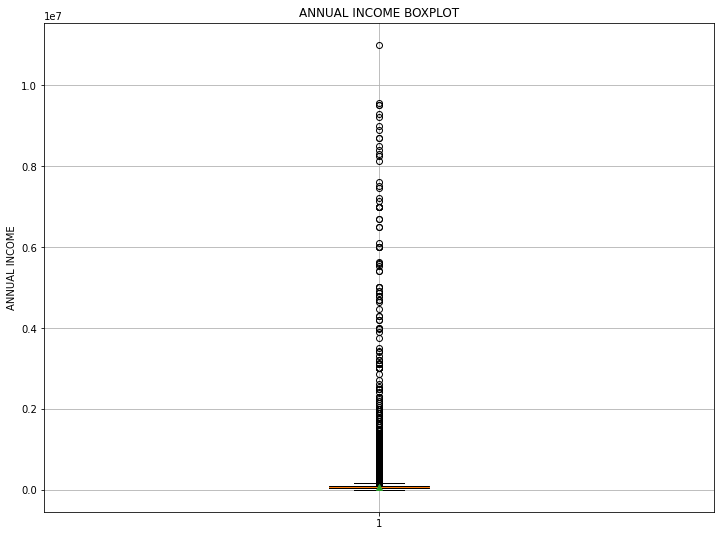

In [15]:
arr = np.asarray(income_values)
mid=np.median(arr)
q1 = np.percentile(arr, 25)
q3 = np.percentile(arr,75)
iqr=(q3-q1)
lower_boundary = q1 - (1.5 * iqr)
upper_boundary = q3 + (1.5 * iqr)
plt.figure(figsize = (12,9))
plt.boxplot(arr, showmeans=True, )
plt.title("ANNUAL INCOME BOXPLOT")
plt.ylabel("ANNUAL INCOME")
plt.grid()
plt.show()

# Breakdown by Loan Status

In [16]:
status_breakdown_df = pd.DataFrame({
    "Count" : df["loan_status"].value_counts(),
    "Percentage" : df["loan_status"].value_counts(normalize = True)
})

status_breakdown_df["Count"] = status_breakdown_df["Count"].map("{:,.0f}".format)
status_breakdown_df["Percentage"] = (status_breakdown_df["Percentage"]*100).map("{0:.2f}%".format)

status_breakdown_df

,Count,Percentage
Good,"1,026,432",79.99%
Bad,"256,711",20.01%


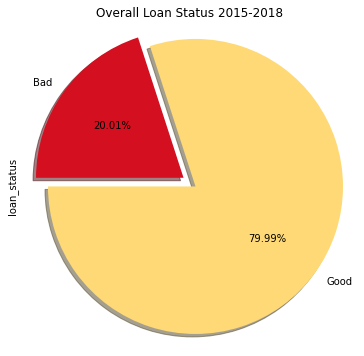

In [17]:
colors = [c1, c2]
explode = (0.1,0)





df["loan_status"].value_counts().plot(kind="pie", title="Overall Loan Status 2015-2018", autopct='%.2f%%', 
                                                 colors=colors, explode=explode, shadow=True, startangle=180, figsize = (6, 6))
# Create axes which are equal so we have a perfect circle
plt.axis("equal")
plt.show()

# Loan Status by State

In [18]:
state_counts_df=df.groupby('loan_status')['addr_state'].value_counts()
state_percentages_df=df.groupby('loan_status')['addr_state'].value_counts(normalize=True)

In [19]:
test = pd.DataFrame(state_percentages_df)
test.rename(columns={'addr_state' : 'percentage'}, inplace=True)
test.reset_index(inplace=True)
test = test[test['loan_status']=="Bad"].copy()
test.percentage = test.percentage*100

In [20]:
test['long_st'] = test['addr_state'].map(short_state_names)
state_dict=dict(zip(test.long_st, test.percentage))

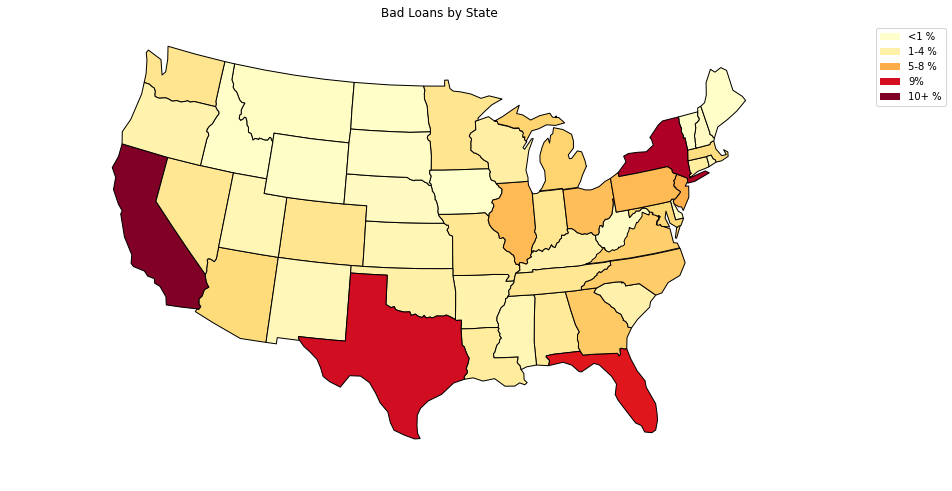

In [21]:
fig = plt.figure(figsize = (12, 9))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

popdensity = state_dict

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

ax.set_title('Bad Loans by State')

#for state in shpreader.Reader(states_shp).geometries():
for astate in shpreader.Reader(states_shp).records():

    try:
        # use the name of this state to get pop_density
        state_dens = popdensity[ astate.attributes['name'] ]
    except:
        state_dens = 0

    edgecolor = 'black'
    facecolor = cmap(state_dens / 10)

    # `astate.geometry` is the polygon to plot
    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
    

labels = ['<1 %', '1-4 %', '5-8 %', '9%', '10+ %']

stateDensLt1 = mpatches.Rectangle((0,0),1,1, facecolor=cmap(0))
stateDensLt4 = mpatches.Rectangle((0,0),1,1, facecolor=cmap(1 / 10))
stateDensLt8 = mpatches.Rectangle((0,0),1,1, facecolor=cmap(4 / 10))
stateDensLt9 = mpatches.Rectangle((0,0),1,1, facecolor=cmap(8 / 10))
stateDensElse = mpatches.Rectangle((0,0),1,1, facecolor=cmap(10 / 10))

ax.legend([stateDensLt1, stateDensLt4, stateDensLt8, stateDensLt9, stateDensElse], labels, bbox_to_anchor=(1,1))

plt.show()

# Breakdown by Loan Purpose

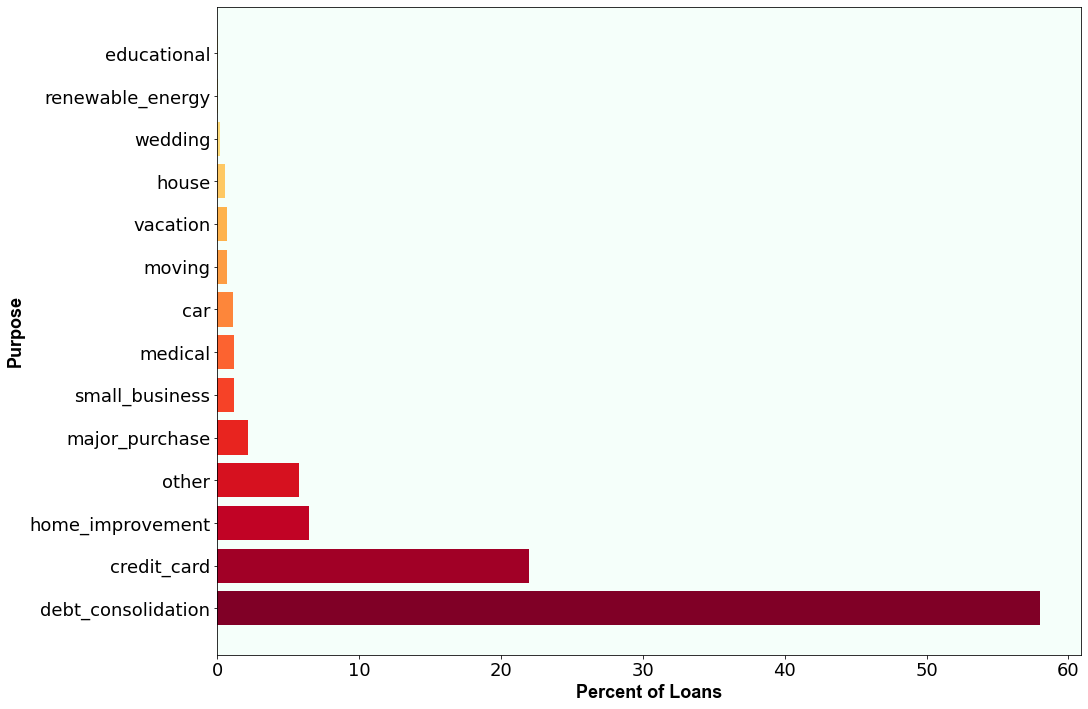

In [22]:
answer = df['purpose'].value_counts(normalize = True)
answer = pd.DataFrame(answer*100)
answer.reset_index(inplace=True)

font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize=(12,9))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel('Percent of Loans', weight='bold', size=18, fontdict=font)
ax.set_ylabel('Purpose', weight='bold', size=18, fontdict=font)
percent = answer['purpose']
students = answer['index']

# colors = ['steelblue','indigo','red','cyan','magenta','yellow','lime','violet','greenyellow']
colors = cmap(np.linspace(1, 0.1, len(students)))

ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)


ax.barh(students,percent, color= colors)
ax.set_facecolor('mintcream')

# Breakdown by Loan Term

In [23]:
term_breakdown_df = pd.DataFrame({
    "Count" : df["term"].value_counts(),
    "Percentage" : df["term"].value_counts(normalize = True)
})

term_breakdown_df["Count"] = term_breakdown_df["Count"].map("{:,.0f}".format)
term_breakdown_df["Percentage"] = (term_breakdown_df["Percentage"]*100).map("{0:.2f}%".format)

term_breakdown_df

,Count,Percentage
36 months,"976,692",76.12%
60 months,"306,451",23.88%


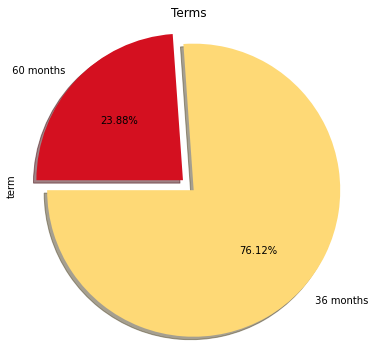

In [24]:
colors = [c1,c2]
explode = (0.1,0)

df["term"].value_counts().plot(kind="pie", title="Terms", autopct='%.2f%%', 
                                                 colors=colors, explode=explode, shadow=True, startangle=180, figsize = (6, 6))
# Create axes which are equal so we have a perfect circle
plt.axis("equal")
plt.show()

# Breakdown by Employment Length

In [25]:
emp_length_breakdown_df = pd.DataFrame({
    "Count" : df["emp_length"].value_counts(),
    "Percentage" : df["emp_length"].value_counts(normalize = True)
})

emp_length_breakdown_df["Count"] = emp_length_breakdown_df["Count"].map("{:,.0f}".format)
emp_length_breakdown_df["Percentage"] = (emp_length_breakdown_df["Percentage"]*100).map("{0:.2f}%".format)

emp_length_breakdown_df

,Count,Percentage
10,"423,148",32.98%
0,"172,127",13.41%
2,"116,481",9.08%
3,"103,042",8.03%
1,"84,945",6.62%
5,"80,711",6.29%
4,"77,106",6.01%
6,"60,339",4.70%
8,"58,604",4.57%
7,"57,610",4.49%


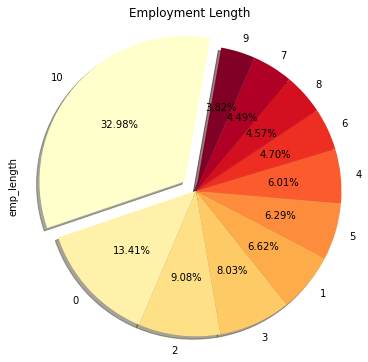

In [26]:
colors = cmap(np.linspace(0, 1, 11))
explode = (0.1,0,0,0,0,0,0,0,0,0,0)

df["emp_length"].value_counts().plot(kind="pie", title="Employment Length", autopct='%.2f%%', 
                                                 colors=colors, explode=explode, shadow=True, startangle=80, figsize = (6, 6))
# Create axes which are equal so we have a perfect circle
plt.axis("equal")
plt.show()

# Breakdown by Lending Club Grade

In [27]:
grade_breakdown_df = pd.DataFrame({
    "Count" : df["grade"].value_counts(),
    "Percentage" : df["grade"].value_counts(normalize = True)
})

grade_breakdown_df["Count"] = grade_breakdown_df["Count"].map("{:,.0f}".format)
grade_breakdown_df["Percentage"] = (grade_breakdown_df["Percentage"]*100).map("{0:.2f}%".format)

grade_breakdown_df

,Count,Percentage
B,"374,821",29.21%
C,"363,045",28.29%
A,"223,353",17.41%
D,"191,720",14.94%
E,"90,273",7.04%
F,"31,087",2.42%
G,"8,844",0.69%


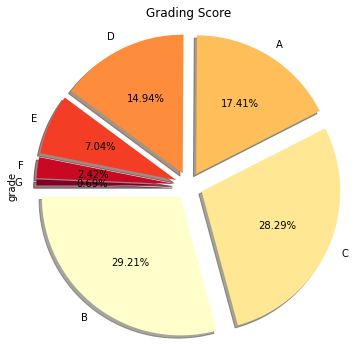

In [28]:
colors = cmap(np.linspace(0, 1, 7))
explode = (0.1,0.1,0.1,0.1,0.1,0.1,0.1)

df["grade"].value_counts().plot(kind="pie", title="Grading Score", autopct='%.2f%%', 
                                                 colors=colors, explode=explode, shadow=True, startangle=180, figsize = (6, 6))
# Create axes which are equal so we have a perfect circle
plt.axis("equal")
plt.show()

# Loan Temporal Analysis by Last Payment Day

In [29]:
# Create new df on last_pymnt_d
date_df = df[["loan_status", "last_pymnt_d"]].copy()

# Groupby last_pymnt_d
date_counts_df = date_df.groupby("last_pymnt_d")["loan_status"].value_counts()
date_percentages_df = date_df.groupby("last_pymnt_d")["loan_status"].value_counts(normalize = True)

# Restructure the df
date_restructured_df = restructure_df(date_counts_df, date_percentages_df, "last_pymnt_d")

# Convert last_pymnt_d to datetime
date_restructured_df['last_pymnt_d']= pd.to_datetime(date_restructured_df['last_pymnt_d'])

date_restructured_df = date_restructured_df.sort_values("last_pymnt_d", ascending=True)

In [30]:
from_ts = '2007-12-01'
to_ts = '2014-12-01'
date_restructured_df = date_restructured_df[(date_restructured_df['last_pymnt_d'] < from_ts) | (date_restructured_df['last_pymnt_d'] > to_ts)]

In [31]:
from_ts = '2018-10-01'
to_ts = '2019-12-01'
date_restructured_df = date_restructured_df[(date_restructured_df['last_pymnt_d'] < from_ts) | (date_restructured_df['last_pymnt_d'] > to_ts)]

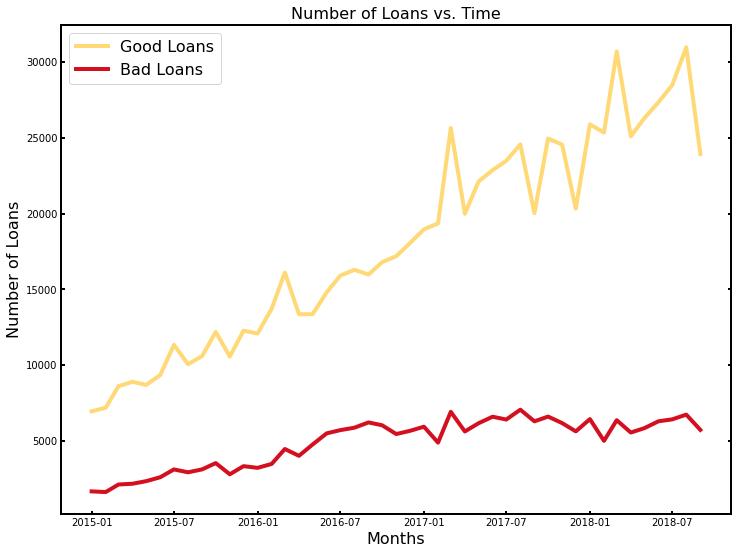

In [32]:
x_df=date_restructured_df["last_pymnt_d"]
y_good_df=date_restructured_df["good_count"]
y_bad_df=date_restructured_df["bad_count"]

fig, ax = plt.subplots(figsize = (12, 9))
    
ax.plot(x_df, y_good_df, "-", color = c1, lw = 4, label = "Good Loans")
ax.plot(x_df, y_bad_df, "-", color = c2, lw = 4, label = "Bad Loans")
  
ax.set_xlabel("Months", fontsize = 16)
ax.set_ylabel("Number of Loans", fontsize = 16)
ax.set_title("Number of Loans vs. Time", fontsize = 16)
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis = "x", labelrotation = 0)
ax.tick_params(axis = "both", which = "both", direction = "in", width = 2)
ax.legend(fontsize = 16)

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)

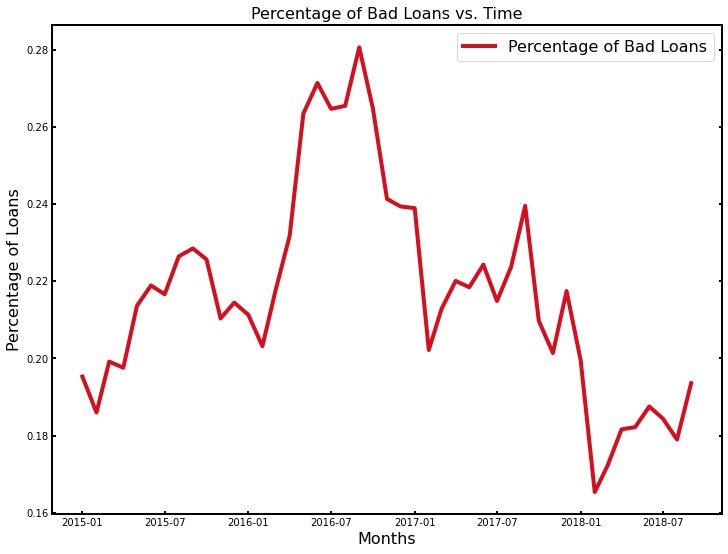

In [33]:
x_df=date_restructured_df["last_pymnt_d"]
y_bad_df=date_restructured_df["bad_percentage"]

fig, ax = plt.subplots(figsize = (12, 9))
    
ax.plot(x_df, y_bad_df, "-", color = c2, lw = 4, label = "Percentage of Bad Loans")
  
ax.set_xlabel("Months", fontsize = 16)
ax.set_ylabel("Percentage of Loans", fontsize = 16)
ax.set_title("Percentage of Bad Loans vs. Time", fontsize = 16)
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis = "x", labelrotation = 0)
ax.tick_params(axis = "both", which = "both", direction = "in", width = 2)
ax.legend(fontsize = 16)

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)

# Risk Probability by Home Ownership Status

In [34]:
# Create df on home_ownership
homeownership_df = df[["loan_status", "home_ownership"]].copy()

homeownership_data = bin_calc_percentages(df = homeownership_df, coltoanalyze = "home_ownership", coltogroupby = "home_ownership", to_bin = False)
homeownership_data["df"]

,home_ownership,bad_count,bad_percentage,good_count,good_percentage
0,ANY,52,0.194757,215,0.805243
1,MORTGAGE,108730,0.172318,522255,0.827682
2,NONE,8,0.156863,43,0.843137
3,OTHER,38,0.208791,144,0.791209
4,OWN,28408,0.206066,109451,0.793934
5,RENT,119475,0.232533,394324,0.767467


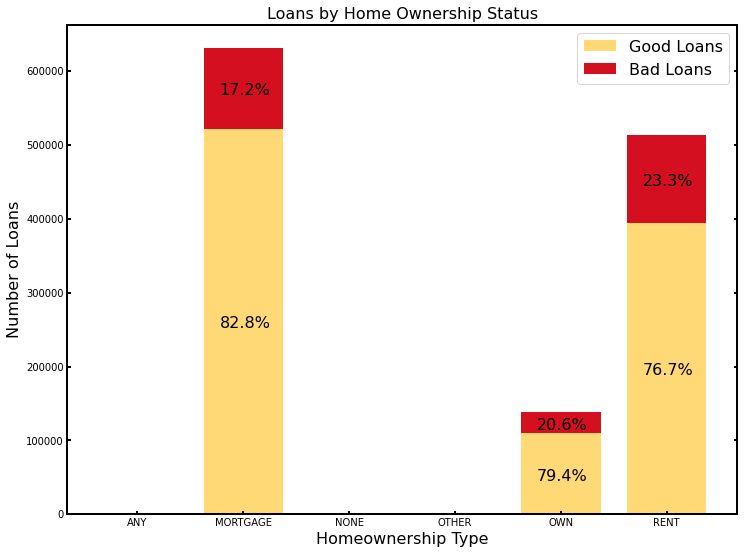

In [35]:
# Plot data
homeownership_labels = {
    "xlabel" : "Homeownership Type",
    "ylabel" : "Number of Loans",
    "title" : "Loans by Home Ownership Status"
}

plot_stackedbar(data = homeownership_data, coltogroupby = "home_ownership", labels = homeownership_labels,
                x_loc = 0.15, y_loc = 9e3, labelrotation = 0, size = (12, 9))

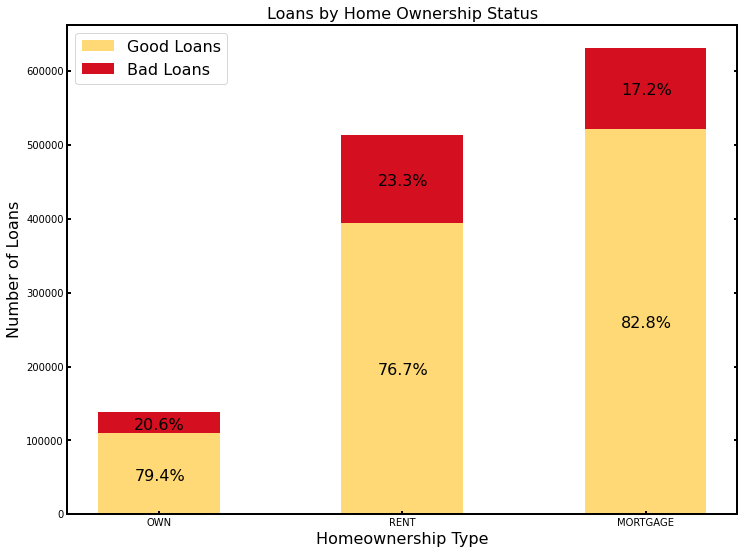

In [36]:
# Same plot w/o the low count categories
homeownership_data_red = {"df" : homeownership_data["df"].loc[homeownership_data["df"]["home_ownership"].isin(["MORTGAGE", "OWN", "RENT"])].sort_values("good_count")}
plot_stackedbar(data = homeownership_data_red, coltogroupby = "home_ownership", labels = homeownership_labels,
                x_loc = 0.15, y_loc = 9e3, labelrotation = 0, size = (12, 9), bar_width = 0.5)

# Risk Probability by Loan Purpose

In [37]:
# Create df on loan purpose
purpose_df = df[["loan_status", "purpose"]].copy()

purpose_data = bin_calc_percentages(df = purpose_df, coltoanalyze = "purpose", coltogroupby = "purpose", to_bin = False)
purpose_data["df"]

,purpose,bad_count,bad_percentage,good_count,good_percentage
0,car,2043,0.145970,11953,0.854030
1,credit_card,47970,0.170070,234091,0.829930
2,debt_consolidation,157578,0.211719,586701,0.788281
3,educational,88,0.208038,335,0.791962
4,home_improvement,14801,0.178592,68075,0.821408
5,house,1495,0.217771,5370,0.782229
6,major_purchase,5227,0.186565,22790,0.813435
7,medical,3183,0.217003,11485,0.782997
8,moving,2091,0.231203,6953,0.768797
9,other,15629,0.210980,58449,0.789020


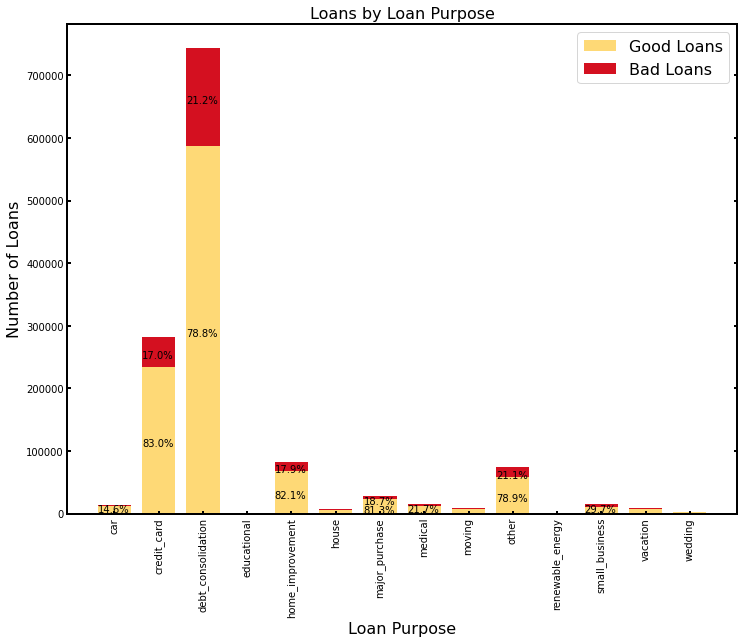

In [38]:
# Plot data
purpose_labels = {
    "xlabel" : "Loan Purpose",
    "ylabel" : "Number of Loans",
    "title" : "Loans by Loan Purpose"
}

plot_stackedbar(data = purpose_data, coltogroupby = "purpose", labels = purpose_labels,
                x_loc = 0, y_loc = 10e3, labelrotation = 90, size = (12, 9), annot_fontsize = 10)

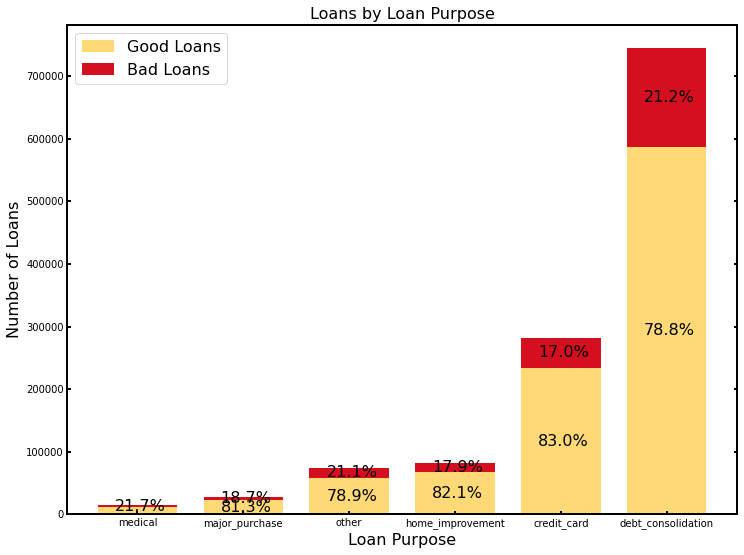

In [39]:
# Same plot w/o the low count categories
purpose_data_red = {"df" : purpose_data["df"].loc[purpose_data["df"]["purpose"].isin(["credit_card", "debt_consolidation", "home_improvement", "major_purchase", "other", "medical"])].sort_values("good_count")}
plot_stackedbar(data = purpose_data_red, coltogroupby = "purpose", labels = purpose_labels,
                x_loc = 0.16, y_loc = 7e3, labelrotation = 0, size = (12, 9), bar_width = 0.75)

# Risk Probability by Length of Employment

In [40]:
# Create new df on employment length
employment_bins =  [0, 1, 3, 5, 7, 9, 10]
employment_bin_names = ["<1 year", "1-3 years", "3-5 Years", "5-7 years" , "7-9 Years", "10+ years"]

# Create df on employment length and clean up data
employment_df = df[["loan_status", "emp_length"]].copy()

# Analyze data
employment_data = bin_calc_percentages(df = employment_df, coltoanalyze = "emp_length", coltogroupby = "emp_bucket",
                                       to_bin = True, bins = employment_bins, bin_names = employment_bin_names, skipLast = False)
employment_data["df"]

,emp_bucket,bad_count,bad_percentage,good_count,good_percentage
0,<1 year,17533,0.206404,67412,0.793596
1,1-3 years,43852,0.199760,175671,0.800240
2,3-5 Years,31211,0.197767,126606,0.802233
3,5-7 years,23028,0.195237,94921,0.804763
4,7-9 Years,21576,0.200457,86058,0.799543
5,10+ years,79813,0.188617,343335,0.811383


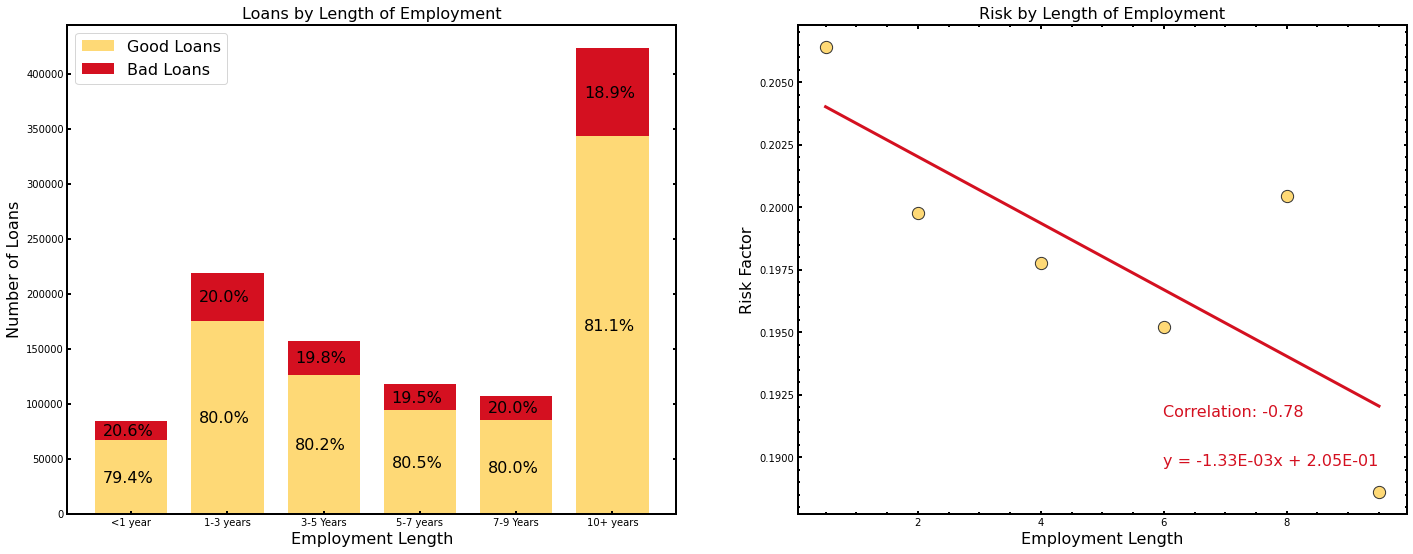

In [41]:
# Plot data
emp_labels = {
    "bar_xlabel" : "Employment Length",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Length of Employment",
    "reg_xlabel" : "Employment Length",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Length of Employment"
}

plot_stackedbar_reg(data = employment_data, coltogroupby = "emp_bucket", labels = emp_labels, x_loc = 0.08, y_loc = 5e3, labelrotation = 0, 
                    size = (24, 9))

# Risk Probability by Annual Income

In [42]:
# Create new df on annual income
income_bins = [0, 30e3, 50e3, 70e3, 100e3, 150e3, 300e3, 1300e3]
income_bin_names = ["<30k", "30-50k", "50-70k", "70-100k" , "100-150k", "150-300k", "300k+"]

income_df = df[["loan_status", "annual_inc"]].copy()

# Analyze data
income_data = bin_calc_percentages(df = income_df, coltoanalyze = "annual_inc", coltogroupby = "income_bucket",
                                   to_bin = True, bins = income_bins, bin_names = income_bin_names, skipLast = False, 
                                   reg_type = "exp", initial_params = [0.137, 9.226e-006, 0.126])
income_data["df"]

,income_bucket,bad_count,bad_percentage,good_count,good_percentage
0,<30k,22249,0.242941,69333,0.757059
1,30-50k,71503,0.225227,245968,0.774773
2,50-70k,67444,0.207825,257079,0.792175
3,70-100k,57612,0.185978,252166,0.814022
4,100-150k,27885,0.162344,143880,0.837656
5,150-300k,9104,0.149942,51613,0.850058
6,300k+,887,0.124247,6252,0.875753


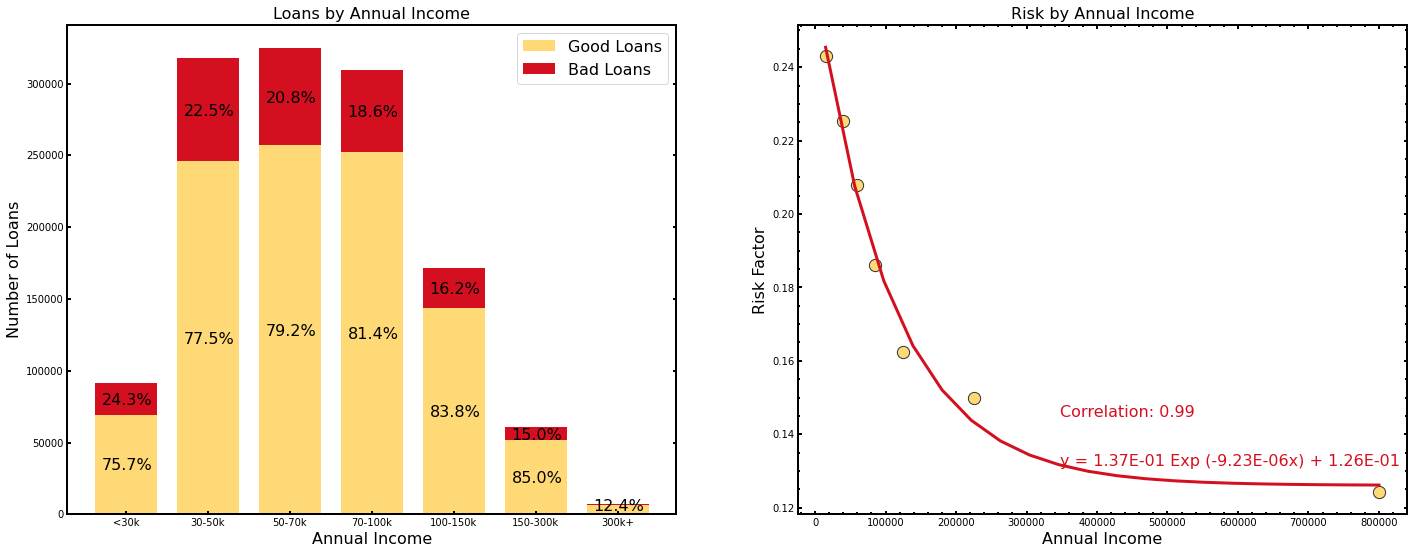

In [43]:
# Plot data
income_labels = {
    "bar_xlabel" : "Annual Income",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Annual Income",
    "reg_xlabel" : "Annual Income",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Annual Income"
}

plot_stackedbar_reg(data = income_data, coltogroupby = "income_bucket", labels = income_labels, x_loc = 0.08, y_loc = 4e3, labelrotation = 0, 
                    size = (24, 9), corr_x = 0.43, eq_x = 0.43)

# Risk Probability by Debt to Income Ratio (DTI)

In [44]:
# Create new df on dti
dti_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
dti_bin_names = ["0-5%", "5-10%", "10-15%", "15-20%", "20-25%", "25-30%", "30-35%", "35-40%", "40-45%", "45-50%"]

dti_df = df[["loan_status", "dti"]].copy()
dti_df.dropna(inplace = True)

# Analyze data
dti_data = bin_calc_percentages(df = dti_df, coltoanalyze = "dti", coltogroupby = "dti_bucket", to_bin = True, bins = dti_bins, 
                                bin_names = dti_bin_names, )
dti_data["df"]

,dti_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-5%,9319,0.145090,54910,0.854910
1,5-10%,25614,0.149135,146137,0.850865
2,10-15%,43703,0.166303,219088,0.833697
3,15-20%,53246,0.191569,224701,0.808431
4,20-25%,50559,0.218697,180624,0.781303
5,25-30%,40018,0.250966,119438,0.749034
6,30-35%,25379,0.288604,62558,0.711396
7,35-40%,8042,0.316726,17349,0.683274
8,40-45%,424,0.395892,647,0.604108
9,45-50%,255,0.427136,342,0.572864


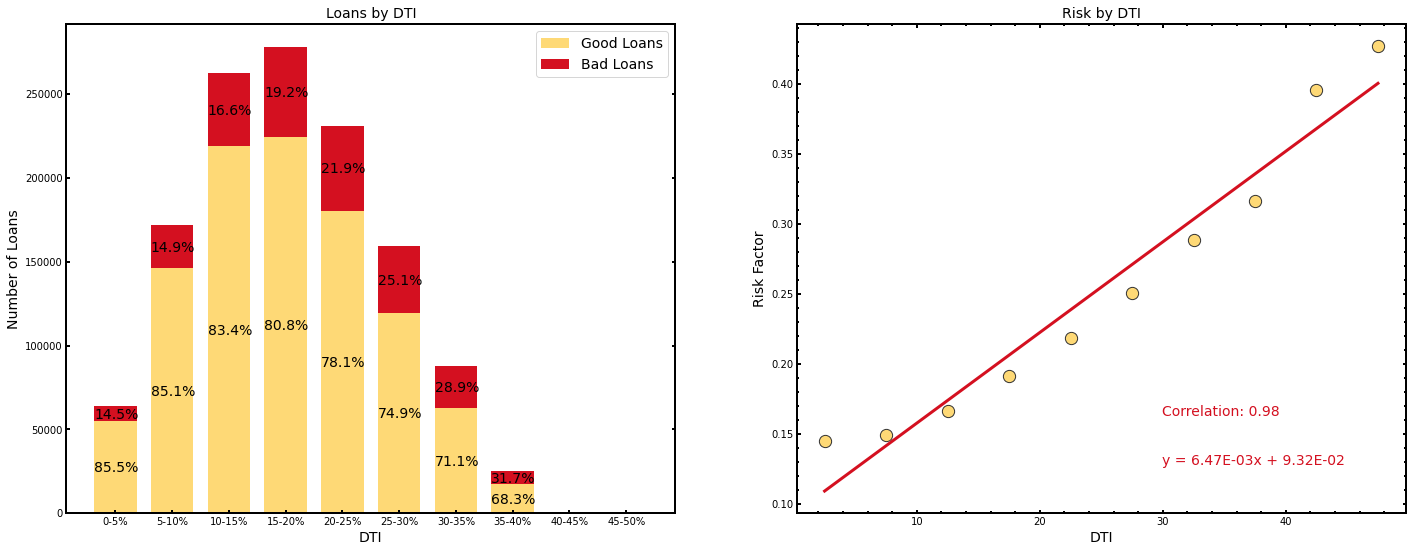

In [45]:
# Plot data
dti_labels = {
    "bar_xlabel" : "DTI",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by DTI",
    "reg_xlabel" : "DTI",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by DTI"
}

plot_stackedbar_reg(data = dti_data, coltogroupby = "dti_bucket", labels = dti_labels, x_loc = 0.00, y_loc = 3e3, labelrotation = 0,
                    size = (24, 9), bar_width = 0.75, annot_fontsize = 14)

# Risk Probability by Loan Amount

In [46]:
# Create new df on dti
# loanamount_bins = [500, 5e3, 10e3, 20e3, 30e3, 40e3]
# loanamount_bin_names = ["0-5k", "5-10k", "10-20k", "20-30k", "30-40k"]

loanamount_bins = [500, 5e3, 10e3, 15e3, 20e3, 25e3, 30e3, 35e3, 40e3]
loanamount_bin_names = ["0-5k", "5-10k", "10-15k", "15-20k", "20-25k", "25-30k", "30-35k", "30-40k"]

loanamount_df = df[["loan_status", "funded_amnt"]].copy()

# Analyze data
loanamount_data = bin_calc_percentages(df = loanamount_df, coltoanalyze = "funded_amnt", coltogroupby = "loanamount_bucket", to_bin = True,
                                       bins = loanamount_bins, bin_names = loanamount_bin_names, skipLast = True)
loanamount_data["df"]

,loanamount_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-5k,27796,0.159024,146995,0.840976
1,5-10k,61944,0.172564,297019,0.827436
2,10-15k,56731,0.208327,215586,0.791673
3,15-20k,46308,0.227033,157662,0.772967
4,20-25k,28806,0.228503,97258,0.771497
5,25-30k,16831,0.231707,55808,0.768293
6,30-35k,16861,0.250703,50394,0.749297
7,30-40k,1433,0.200897,5700,0.799103


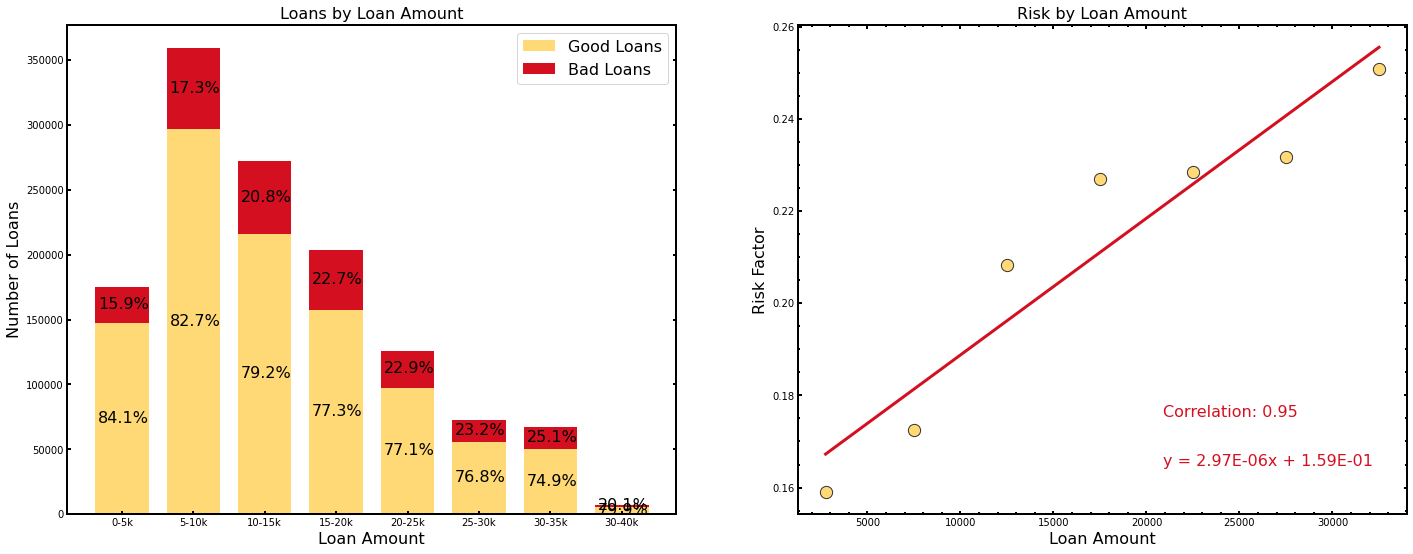

In [47]:
# Plot data
loanamount_labels = {
    "bar_xlabel" : "Loan Amount",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Loan Amount",
    "reg_xlabel" : "Loan Amount",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Loan Amount"
}

plot_stackedbar_reg(data = loanamount_data, coltogroupby = "loanamount_bucket", labels = loanamount_labels, x_loc = 0.04, y_loc = 3e3,
                    labelrotation = 0, size = (24, 9))

# Risk Probability by Total current balance / Annual Income

In [48]:
# Create new df on dti
totcurbal_annualinc_bins = [0, 1, 2, 3, 4, 5, 10, 50]
totcurbal_annualinc_bin_names = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-10", "10-50"]

totcurbal_annualinc_df = df[["loan_status", "tot_cur_bal", "annual_inc"]].copy()
totcurbal_annualinc_df.dropna(inplace = True)
totcurbal_annualinc_df["totcurbal_annualinc"] = totcurbal_annualinc_df["tot_cur_bal"] / totcurbal_annualinc_df["annual_inc"]

# Analyze data
totcurbal_annualinc_data = bin_calc_percentages(df = totcurbal_annualinc_df, coltoanalyze = "totcurbal_annualinc", 
                                                coltogroupby = "totcurbal_annualinc_bucket", to_bin = True, bins = totcurbal_annualinc_bins, 
                                                bin_names = totcurbal_annualinc_bin_names, skipLast = False, add_reg_todict = False)
totcurbal_annualinc_data["df"]

,totcurbal_annualinc_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-1,123848,0.225395,425622,0.774605
1,1-2,41409,0.204373,161206,0.795627
2,2-3,34303,0.174080,162750,0.825920
3,3-4,25502,0.177053,118534,0.822947
4,4-5,12602,0.174567,59588,0.825433
5,5-10,7794,0.166849,38919,0.833151
6,10-50,89,0.189765,380,0.810235


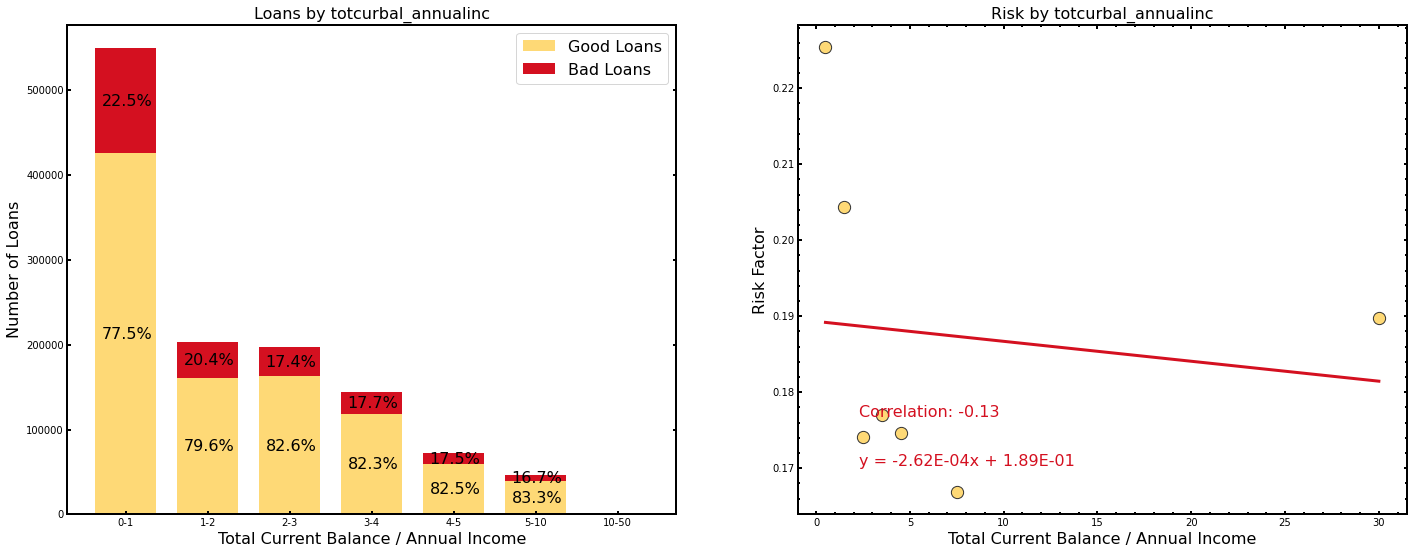

In [49]:
# Plot data
totcurbal_annualinc_labels = {
    "bar_xlabel" : "Total Current Balance / Annual Income",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by totcurbal_annualinc",
    "reg_xlabel" : "Total Current Balance / Annual Income",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by totcurbal_annualinc"
}

plot_stackedbar_reg(data = totcurbal_annualinc_data, coltogroupby = "totcurbal_annualinc_bucket", labels = totcurbal_annualinc_labels,
                    x_loc = 0.08, y_loc = 6e3, labelrotation = 0, size = (24, 9), corr_x = 0.1, eq_x = 0.1)

# Risk Probability by Mortgage Accounts

In [50]:
# Create new df on mort_acc
mort_bins = [0, 1, 2, 3, 4, 5, 10, 20, 30]
mort_bin_names = ["0-1", "1-2", "2-3", "3-4", "4-5", "5-10", "10-20", "20-30"]

mort_df = df[["loan_status", "mort_acc"]].copy()

# Analyze data
mort_data = bin_calc_percentages(df = mort_df, coltoanalyze = "mort_acc", coltogroupby = "mort_bucket", to_bin = True, bins = mort_bins, 
                                 bin_names = mort_bin_names, skipLast = False, reg_type = "exp", initial_params = [0.214, 0.089, 0.120])
mort_data["df"]

,mort_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-1,43525,0.203545,170310,0.796455
1,1-2,32746,0.183552,145656,0.816448
2,2-3,22529,0.170708,109445,0.829292
3,3-4,14494,0.160752,75670,0.839248
4,4-5,8452,0.153695,46540,0.846305
5,5-10,8839,0.143183,52893,0.856817
6,10-20,344,0.125685,2393,0.874315
7,20-30,10,0.117647,75,0.882353


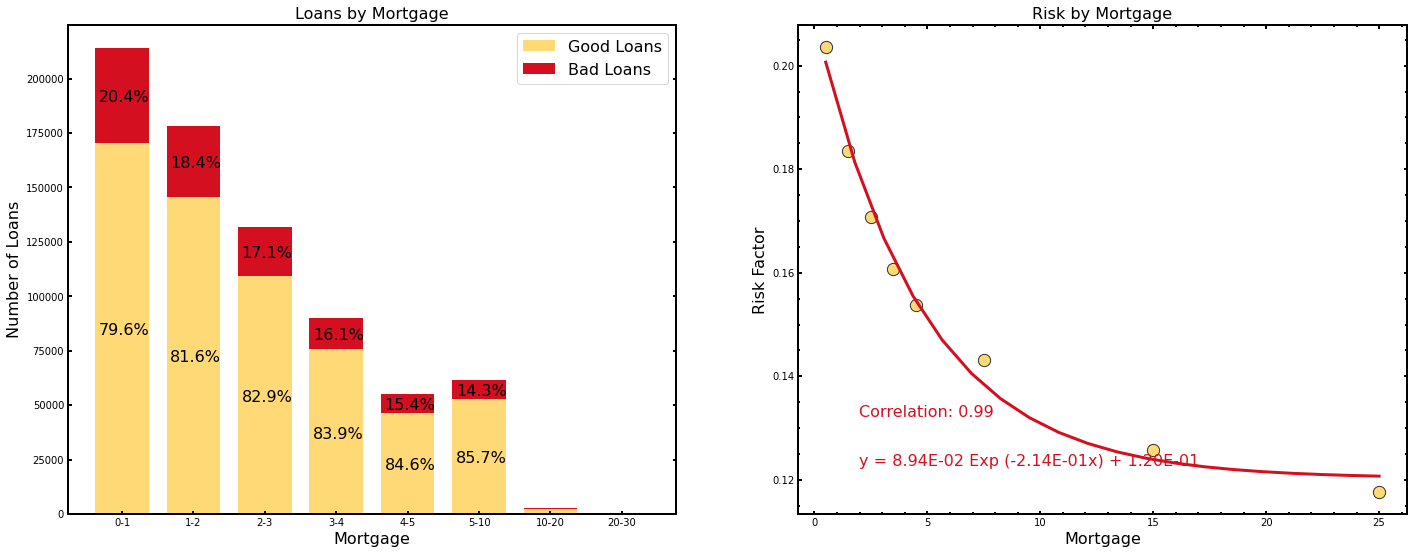

In [51]:
# Plot data
mort_labels = {
    "bar_xlabel" : "Mortgage",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Mortgage",
    "reg_xlabel" : "Mortgage",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Mortgage"
}

plot_stackedbar_reg(data = mort_data, coltogroupby = "mort_bucket", labels = mort_labels, x_loc = 0.05, y_loc = 3e3,
                    labelrotation = 0, size = (24, 9), corr_x = 0.1, eq_x = 0.1)

# Risk Probability by Number of Open Accounts

In [52]:
# Create new df on open_acc
openacc_bins = [0, 5, 10, 15, 20, 25, 90]
openacc_bin_names = ["0-5", "5-10", "10-15", "15-20", "20-25", "25+"]

openacc_df = df[["loan_status", "open_acc"]].copy()

# Analyze data
openacc_data = bin_calc_percentages(df = openacc_df, coltoanalyze = "open_acc", coltogroupby = "openacc_bucket",
                                                  to_bin = True, bins = openacc_bins, bin_names = openacc_bin_names, skipLast = True)
openacc_data["df"]

,openacc_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-5,20828,0.181752,93768,0.818248
1,5-10,98646,0.191835,415578,0.808165
2,10-15,82109,0.205168,318094,0.794832
3,15-20,35551,0.211619,132444,0.788381
4,20-25,12934,0.221223,45532,0.778777
5,25+,6635,0.240233,20984,0.759767


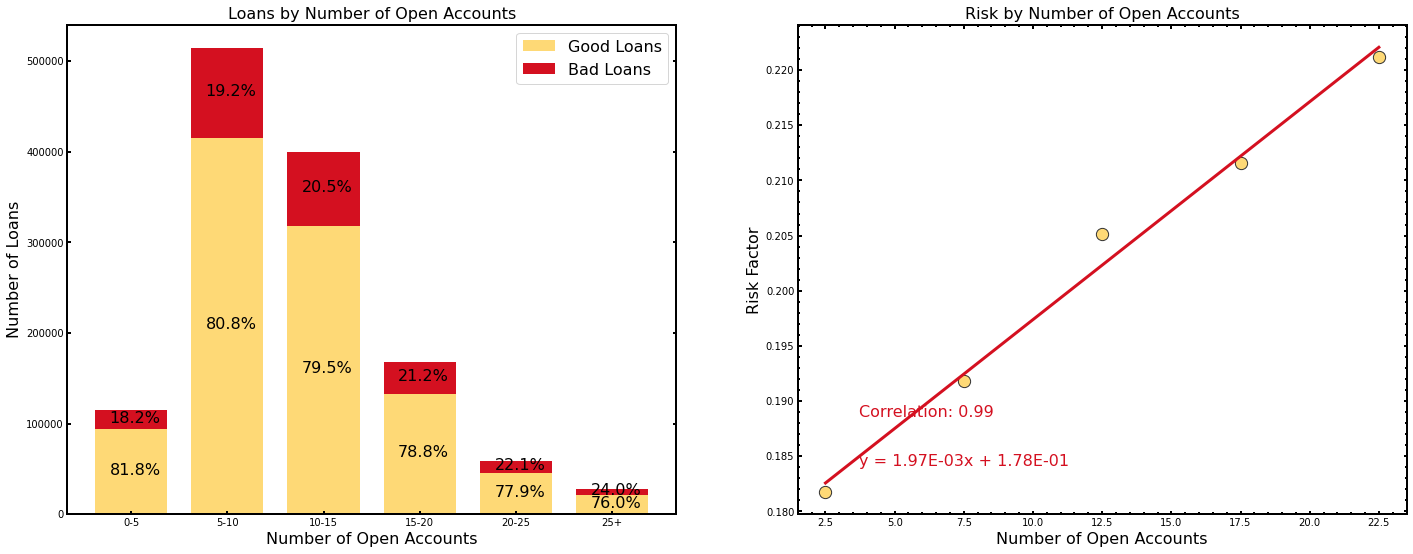

In [53]:
# Plot data
openacc_labels = {
    "bar_xlabel" : "Number of Open Accounts",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Number of Open Accounts",
    "reg_xlabel" : "Number of Open Accounts",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Number of Open Accounts"
}

plot_stackedbar_reg(data = openacc_data, coltogroupby = "openacc_bucket", labels = openacc_labels, x_loc = 0.15, y_loc = 3e3,
                    labelrotation = 0, size = (24, 9), corr_x = 0.1, eq_x = 0.1)

# Risk Probability by Percent of Non-Delinquent Accounts

In [54]:
# Create new df on pct_tl_nvr_dlq 
percgoodacc_bins = [80, 90, 93, 96, 98, 100]
percgoodacc_bin_names = ["80-90%", "90-93%", "93-96%", "96-98%", "98-100%"]

percgoodacc_df = df[["loan_status", "pct_tl_nvr_dlq"]].copy()

# Analyze data
percgoodacc_data = bin_calc_percentages(df = percgoodacc_df, coltoanalyze = "pct_tl_nvr_dlq", coltogroupby = "percgoodacc_bucket",
                                                  to_bin = True, bins = percgoodacc_bins, bin_names = percgoodacc_bin_names, skipLast = False)
percgoodacc_data["df"]

,percgoodacc_bucket,bad_count,bad_percentage,good_count,good_percentage
0,80-90%,36306,0.210622,136069,0.789378
1,90-93%,20252,0.210601,75911,0.789399
2,93-96%,31768,0.208497,120599,0.791503
3,96-98%,18045,0.198810,72720,0.801190
4,98-100%,118668,0.197114,483359,0.802886


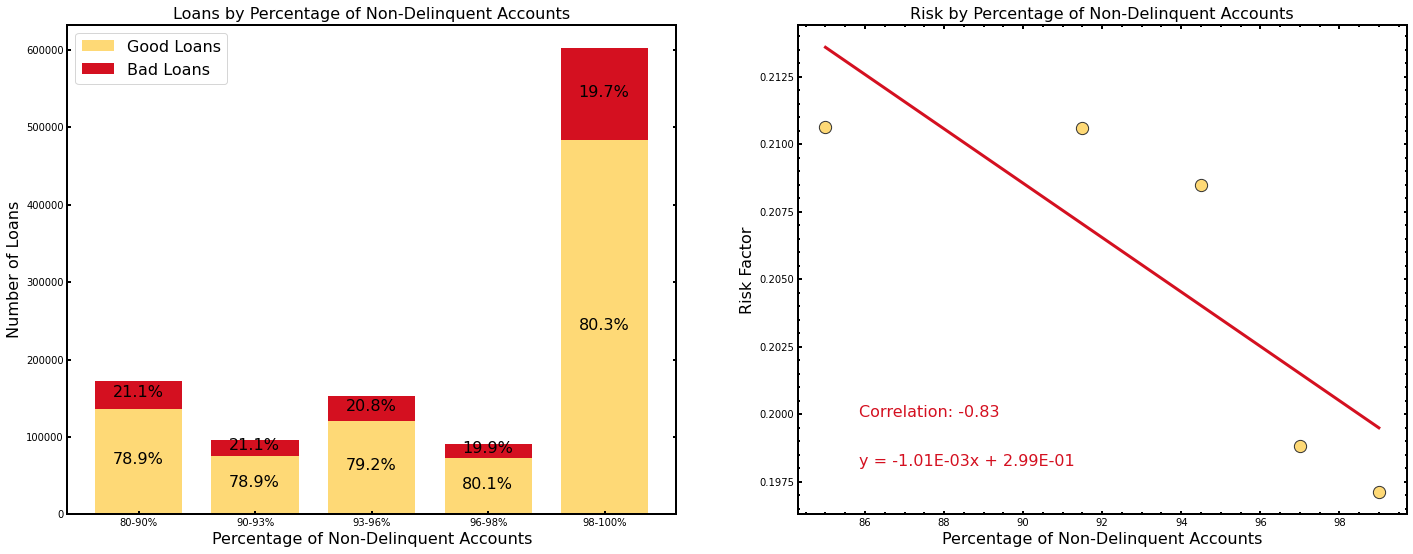

In [55]:
# Plot data
percgoodacc_labels = {
    "bar_xlabel" : "Percentage of Non-Delinquent Accounts",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Percentage of Non-Delinquent Accounts",
    "reg_xlabel" : "Percentage of Non-Delinquent Accounts",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Percentage of Non-Delinquent Accounts"
}

plot_stackedbar_reg(data = percgoodacc_data, coltogroupby = "percgoodacc_bucket", labels = percgoodacc_labels, 
                    x_loc = 0.15, y_loc = 3e3, labelrotation = 0, size = (24, 9), corr_x = 0.1, eq_x = 0.1)

# Risk Probability by Number of Unsatisfactory Accounts / Total Number of Accounts

In [56]:
# Create new df on num_sats / total_acc
numsats_totacc_bins = [0, 20, 40, 60, 80, 100]
numsats_totacc_bin_names = ["<20%", "20-40%", "40-60%", "60-80%", "80-100%"]

numsats_totacc_df = df[["loan_status", "num_sats", "total_acc"]].copy()
numsats_totacc_df["numsats_totacc"] = numsats_totacc_df["num_sats"] / numsats_totacc_df["total_acc"] * 100

# Analyze data
numsats_totacc_data = bin_calc_percentages(df = numsats_totacc_df, coltoanalyze = "numsats_totacc", coltogroupby = "numsats_totacc_bucket",
                                                  to_bin = True, bins = numsats_totacc_bins, bin_names = numsats_totacc_bin_names, skipLast = False)
numsats_totacc_data["df"]

,numsats_totacc_bucket,bad_count,bad_percentage,good_count,good_percentage
0,<20%,4682,0.164708,23744,0.835292
1,20-40%,65271,0.179247,298869,0.820753
2,40-60%,102471,0.199397,411433,0.800603
3,60-80%,56900,0.232134,188217,0.767866
4,80-100%,18355,0.251604,54597,0.748396


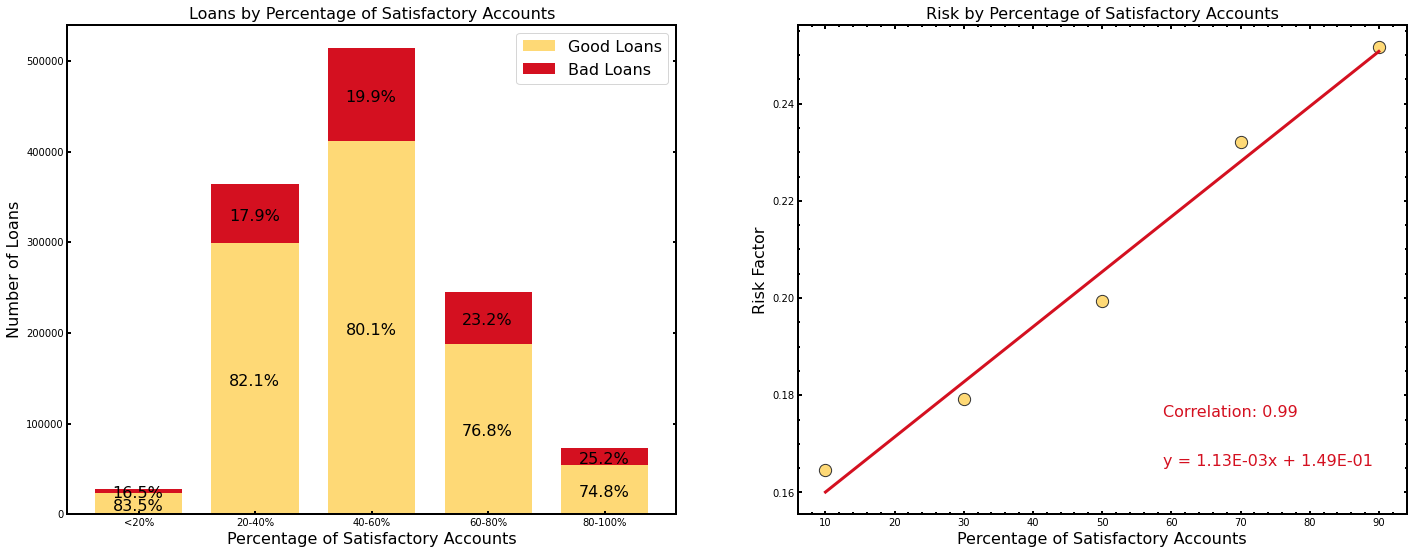

In [57]:
# Plot data
numsats_totacc_labels = {
    "bar_xlabel" : "Percentage of Satisfactory Accounts",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Percentage of Satisfactory Accounts",
    "reg_xlabel" : "Percentage of Satisfactory Accounts",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Percentage of Satisfactory Accounts"
}

plot_stackedbar_reg(data = numsats_totacc_data, coltogroupby = "numsats_totacc_bucket", labels = numsats_totacc_labels,
                    x_loc = 0.15, y_loc = 8e3, labelrotation = 0, size = (24, 9), corr_x = 0.6, eq_x = 0.6)

# Risk Probability by Balance to Credit Limit

In [58]:
# Create new df on all_util
util_bins = [0, 25, 50, 75, 100, 125, 150, 200]
util_bin_names = ["0-25", "25-50", "50-75", "75-100", "100-125", "125-150", "150+"]

util_df = df[["loan_status", "all_util"]].copy()

# Analyze data
util_data = bin_calc_percentages(df = util_df, coltoanalyze = "all_util", coltogroupby = "util_bucket",
                                                  to_bin = True, bins = util_bins, bin_names = util_bin_names, skipLast = False)
util_data["df"]

,util_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0-25,4828,0.148212,27747,0.851788
1,25-50,23696,0.183525,105420,0.816475
2,50-75,51863,0.241998,162449,0.758002
3,75-100,25927,0.276723,67766,0.723277
4,100-125,1498,0.270056,4049,0.729944
5,125-150,114,0.335294,226,0.664706
6,150+,12,0.352941,22,0.647059


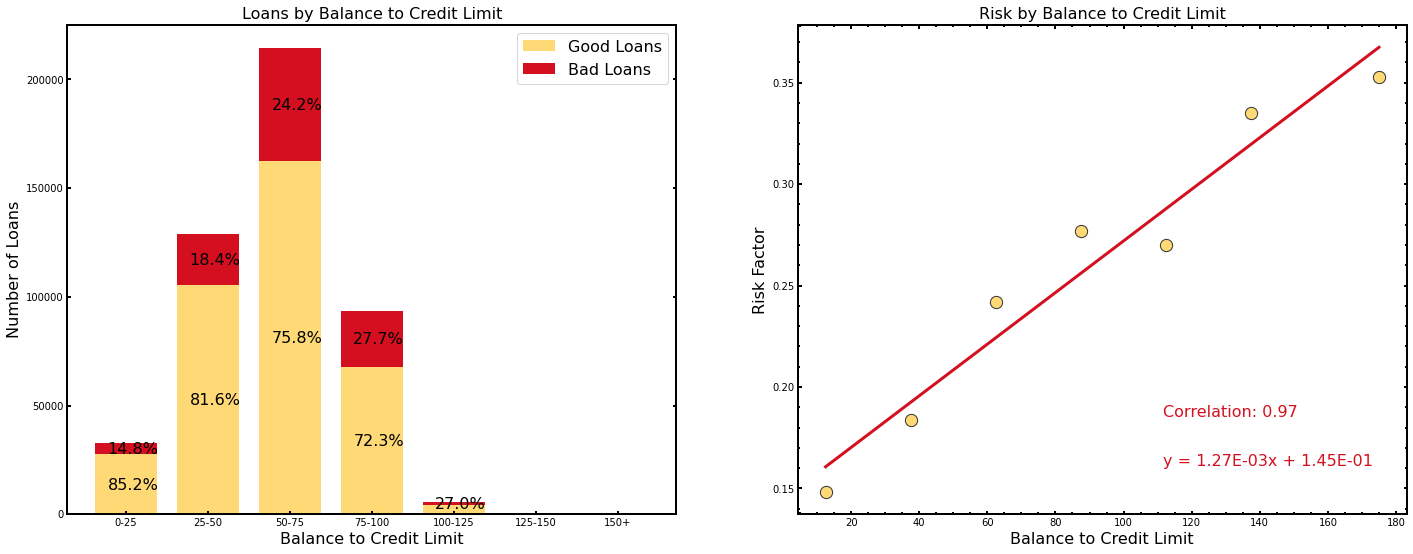

In [59]:
# Plot data
util_labels = {
    "bar_xlabel" : "Balance to Credit Limit",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Balance to Credit Limit",
    "reg_xlabel" : "Balance to Credit Limit",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Balance to Credit Limit"
}

plot_stackedbar_reg(data = util_data, coltogroupby = "util_bucket", labels = util_labels, x_loc = 0.15, y_loc = 2.5e3, labelrotation = 0,
                    size = (24, 9), corr_x = 0.6, eq_x = 0.6)

# Risk Probability by DSCR (Debt-Service Coverage Ratio)

In [60]:
# Create new df on all_util
dscr_bins = [0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.5]
dscr_bin_names = ["0.8-1", "1-1.2", "1.2-1.4", "1.4-1.6", "1.6-1.8", "1.8-2", "2-2.2", "2.2-2.5"]
dscr_df = df[["loan_status", "annual_inc", "installment", "dti", "grade", "int_rate"]].copy()
dscr_df = dscr_df.loc[dscr_df["dti"] >= 0]
dscr_df["dscr"] = 1 / (12 * dscr_df["installment"] / dscr_df["annual_inc"] + dscr_df["dti"] / 100 + 0.4)

# Analyze data
dscr_data = bin_calc_percentages(df = dscr_df, coltoanalyze = "dscr", coltogroupby = "dscr_bucket",
                                                  to_bin = True, bins = dscr_bins, bin_names = dscr_bin_names, skipLast = True, reg_type = "exp")
dscr_data["df"]

,dscr_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0.8-1,183,0.450739,223,0.549261
1,1-1.2,21291,0.331837,42870,0.668163
2,1.2-1.4,80346,0.258727,230198,0.741273
3,1.4-1.6,79837,0.201664,316055,0.798336
4,1.6-1.8,47660,0.160785,248760,0.839215
5,1.8-2,20146,0.132887,131457,0.867113
6,2-2.2,6092,0.114948,46906,0.885052
7,2.2-2.5,1156,0.104013,9958,0.895987


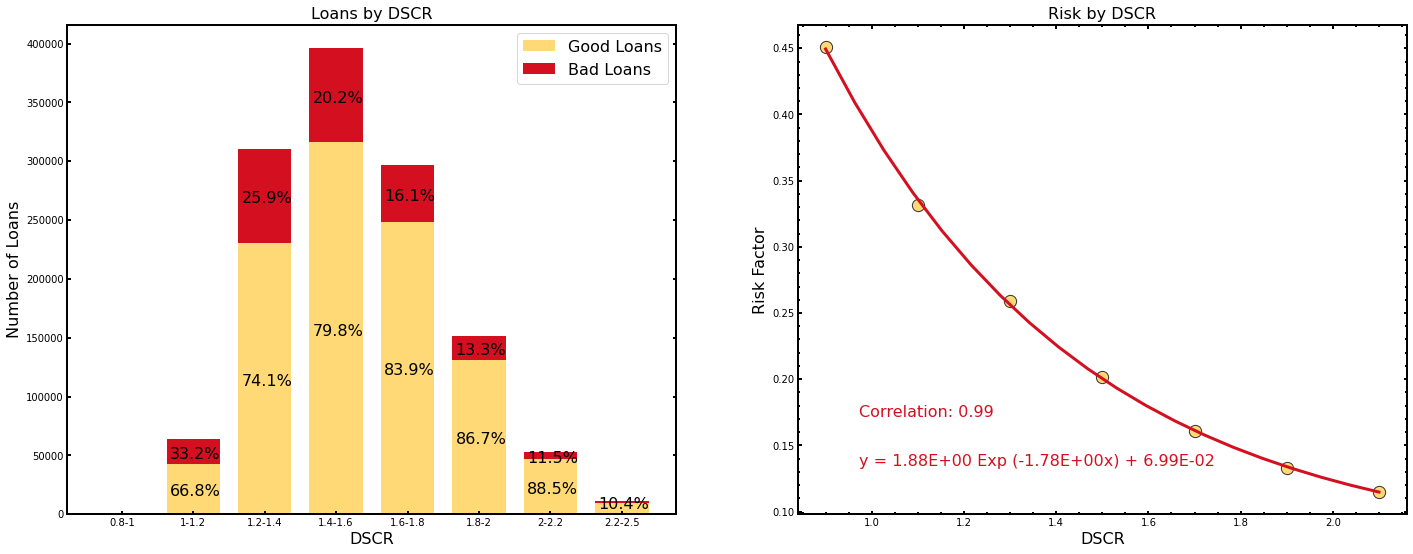

In [61]:
# Plot data
dscr_labels = {
    "bar_xlabel" : "DSCR",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by DSCR",
    "reg_xlabel" : "DSCR",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by DSCR"
}

plot_stackedbar_reg(data = dscr_data, coltogroupby = "dscr_bucket", labels = dscr_labels, x_loc = 0.05, y_loc = 6e3, labelrotation = 0,
                    size = (24, 9), corr_x = 0.1, eq_x = 0.1)

In [62]:
dscr_means_df = dscr_df.groupby("grade").agg({
    "grade" : "count",
    "dscr" : "mean",
    "int_rate" : "mean"
}).rename(columns = {
    "grade" : "Count",
    "dscr" : "Avg DSCR",
    "int_rate" : "Avg Interest Rate"
}).reset_index()

dscr_means_df["Count"] = dscr_means_df["Count"].map("{:,.0f}".format)
dscr_means_df["Avg DSCR"] = dscr_means_df["Avg DSCR"].map("{:,.4f}".format)
dscr_means_df["Avg Interest Rate"] = dscr_means_df["Avg Interest Rate"].map("{0:.2f}%".format)

dscr_means_df

,grade,Count,Avg DSCR,Avg Interest Rate
0,A,"223,353",1.6474,7.13%
1,B,"374,820",1.5882,10.69%
2,C,"363,045",1.5394,14.01%
3,D,"191,720",1.4921,17.66%
4,E,"90,273",1.4606,21.01%
5,F,"31,087",1.4405,24.76%
6,G,"8,844",1.4233,27.40%


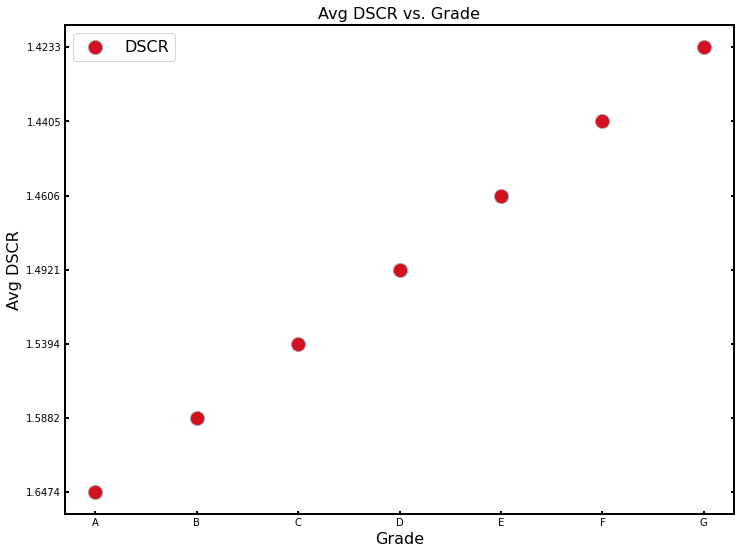

In [63]:
x_df=dscr_means_df["grade"]
y_df=dscr_means_df["Avg DSCR"]

fig, ax = plt.subplots(figsize = (12, 9))
    
ax.scatter(x_df, y_df, marker = "o", color = c2, s = 200, edgecolor = "darkgrey", label = "DSCR")
  
ax.set_xlabel("Grade", fontsize = 16)
ax.set_ylabel("Avg DSCR", fontsize = 16)
ax.set_title("Avg DSCR vs. Grade", fontsize = 16)
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis = "x", labelrotation = 0)
ax.tick_params(axis = "both", which = "both", direction = "in", width = 2)
ax.legend(fontsize = 16)

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)

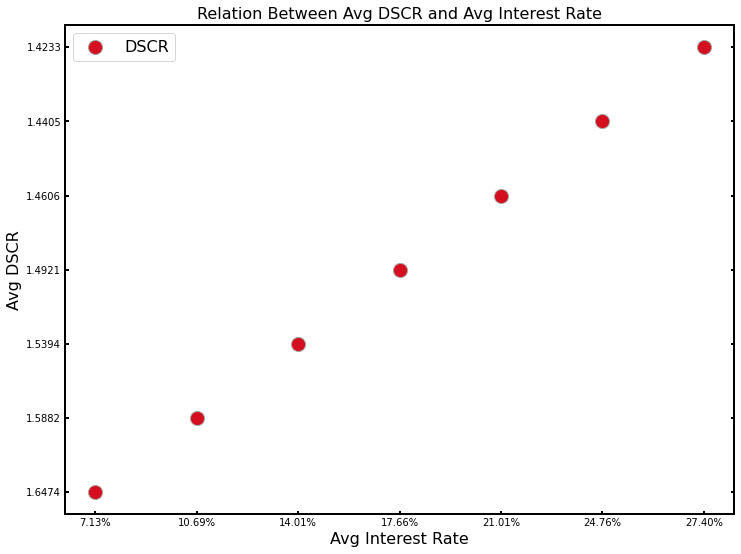

In [64]:
x_df=dscr_means_df["Avg Interest Rate"]
y_df=dscr_means_df["Avg DSCR"]

fig, ax = plt.subplots(figsize = (12, 9))
    
ax.scatter(x_df, y_df, marker = "o", color = c2, s = 200, edgecolor = "darkgrey", label = "DSCR")
  
ax.set_xlabel("Avg Interest Rate", fontsize = 16)
ax.set_ylabel("Avg DSCR", fontsize = 16)
ax.set_title("Relation Between Avg DSCR and Avg Interest Rate", fontsize = 16)
ax.yaxis.set_ticks_position("both")
ax.tick_params(axis = "x", labelrotation = 0)
ax.tick_params(axis = "both", which = "both", direction = "in", width = 2)
ax.legend(fontsize = 16)

for axis in ['top','bottom','left','right'] :
    ax.spines[axis].set_linewidth(2)

# Overall Risk Estimation - Risk Grade

In [65]:
# Add normalized columns to df
df["totcurbal_annualinc"] = df["tot_cur_bal"] / df["annual_inc"]
df["numsats_totacc"] = df["num_sats"] / df["total_acc"]
df["dscr"] = 1 / (12 * df["installment"] / df["annual_inc"] + df["dti"] / 100 + 0.4)

In [66]:
# # Fine tune weights
# weights = {
#     'emp_length': 1,
#     'home_ownership': 1,
#     'purpose': 1,
#     'annual_inc': 1,
#     'dti': 1,
#     'funded_amnt': 1,
#     'totcurbal_annualinc': 1,
#     'mort_acc': 1,
#     'open_acc': 1,
#     'pct_tl_nvr_dlq': 1,
#     'numsats_totacc': 1,
#     'all_util': 1,
#     'dscr': 1
# }

# for key in reg_dict.keys() :
#     reg_dict[key]["weight"] = weights[key]

In [67]:
# Calcutale risks using results of categorical analysis and regression for all ariables
risks_df = pd.DataFrame({"loan_status" : df["loan_status"]})

for key in reg_dict.keys() :
    if reg_dict[key]["type"] == "lin" :
        risks_df[key] = (reg_dict[key]["weight"] * (df[key] * reg_dict[key]["params"][0] + reg_dict[key]["params"][1])) #/ len(reg_dict.keys()) #.fillna(0)
    elif reg_dict[key]["type"] == "exp":
        risks_df[key] = (reg_dict[key]["weight"] * func(df[key], *reg_dict[key]["params"])) #/ len(reg_dict.keys()) #.fillna(0)
    else :
        risks_df[key] = df[key].apply(lambda x : reg_dict[key]["params"][x] )#/ len(reg_dict.keys()))

In [68]:
# Average over all risks
risks_df["risk_grade"] = risks_df[reg_dict.keys()].mean(axis=1)
df["risk_grade"] = risks_df[reg_dict.keys()].mean(axis=1)

# Risk Grade

In [69]:
# Create new df on risk
risk_bins = [0.15, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.243]
risk_bin_names = ["0.15-0.18", "0.18-0.19", "0.19-0.20", "0.20-0.21", "0.21-0.22", "0.22-0.23", "0.23-0.243"]

risk_df = df[["loan_status", "risk_grade", "grade"]].copy()

# Analyze data
risk_data = bin_calc_percentages(df = risk_df, coltoanalyze = "risk_grade", coltogroupby = "risk_bucket",
                                                  to_bin = True, bins = risk_bins, bin_names = risk_bin_names, skipLast = False, add_reg_todict = False)
risk_data["df"]

,risk_bucket,bad_count,bad_percentage,good_count,good_percentage
0,0.15-0.18,8347,0.088253,86233,0.911747
1,0.18-0.19,43223,0.136575,273255,0.863425
2,0.19-0.20,83039,0.192377,348608,0.807623
3,0.20-0.21,77521,0.252755,229183,0.747245
4,0.21-0.22,37876,0.323992,79028,0.676008
5,0.22-0.23,6451,0.396253,9829,0.603747
6,0.23-0.243,254,0.461818,296,0.538182


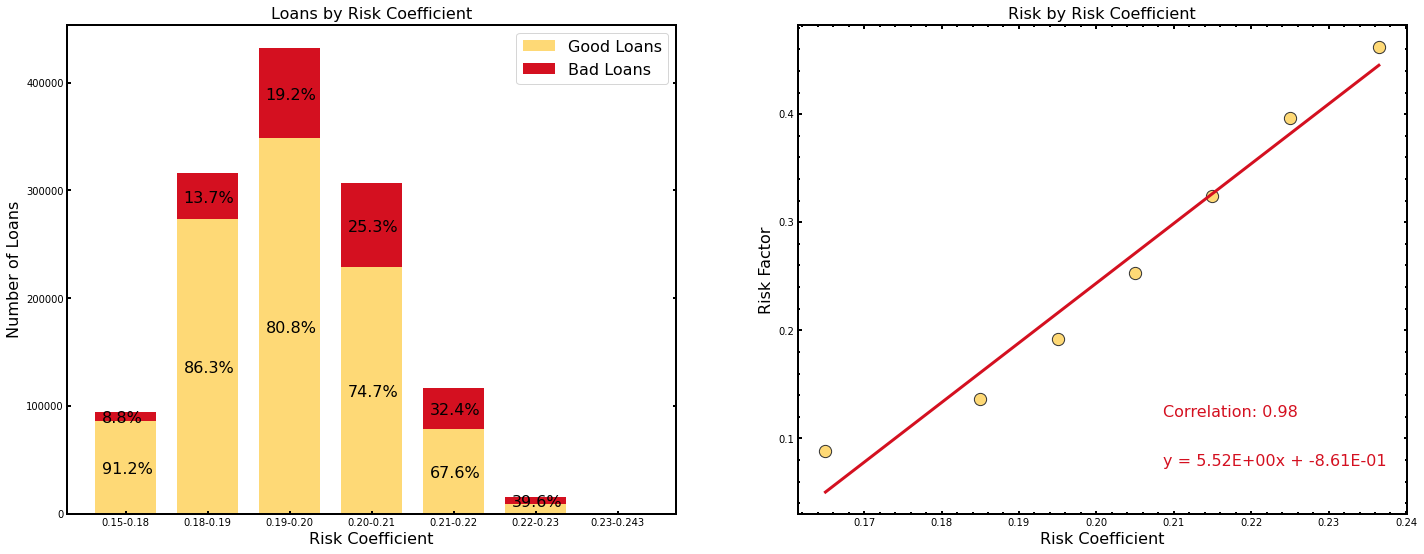

In [70]:
# Plot data
risk_labels = {
    "bar_xlabel" : "Risk Coefficient",
    "bar_ylabel" : "Number of Loans",
    "bar_title" : "Loans by Risk Coefficient",
    "reg_xlabel" : "Risk Coefficient",
    "reg_ylabel" : "Risk Factor",
    "reg_title" : "Risk by Risk Coefficient"
}

plot_stackedbar_reg(data = risk_data, coltogroupby = "risk_bucket", labels = risk_labels, x_loc = 0.08, y_loc = 6e3, labelrotation = 0, 
                    size = (24, 9), corr_x = 0.6, eq_x = 0.6)

# Lending Club Grades

In [71]:
# Create new df on grade
grade_df = df[["loan_status", "grade"]].copy()

# Analyze data
grade_data = bin_calc_percentages(df = grade_df, coltoanalyze = "grade", coltogroupby = "grade", to_bin = False, add_reg_todict = False)
grade_data["df"]

,grade,bad_count,bad_percentage,good_count,good_percentage
0,A,13485,0.060375,209868,0.939625
1,B,50269,0.134115,324552,0.865885
2,C,81484,0.224446,281561,0.775554
3,D,58243,0.303792,133477,0.696208
4,E,34786,0.385342,55487,0.614658
5,F,14054,0.452086,17033,0.547914
6,G,4390,0.496382,4454,0.503618


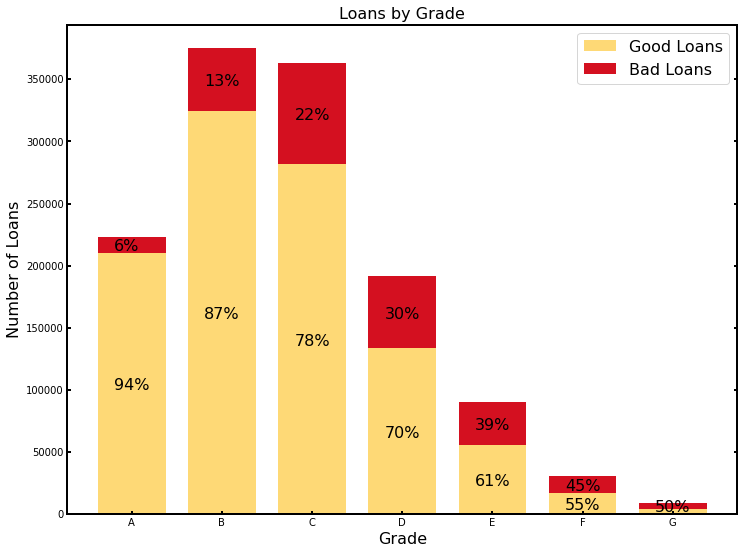

In [72]:
# Plot data
grade_labels = {
    "xlabel" : "Grade",
    "ylabel" : "Number of Loans",
    "title" : "Loans by Grade"
}

plot_stackedbar(data = grade_data, coltogroupby = "grade", labels = grade_labels, x_loc = 0.18, y_loc = 5e3, labelrotation = 0, size = (12, 9), sigfigs = 0, annot_fontsize = 16)

# Lending Club Subgrades

In [73]:
# Create new df on subgrade
subgrade_df = df[["loan_status", "sub_grade"]].copy()

# Analyze data
subgrade_data = bin_calc_percentages(df = subgrade_df, coltoanalyze = "sub_grade", coltogroupby = "sub_grade", to_bin = False, add_reg_todict = False)
subgrade_data["df"]

,sub_grade,bad_count,bad_percentage,good_count,good_percentage
0,A1,1346,0.032935,39522,0.967065
1,A2,1633,0.046363,33589,0.953637
2,A3,1984,0.054980,34102,0.945020
3,A4,3390,0.068039,46434,0.931961
4,A5,5132,0.083647,56221,0.916353
5,B1,7057,0.104133,60712,0.895867
6,B2,8046,0.113758,62683,0.886242
7,B3,10177,0.129762,68251,0.870238
8,B4,11853,0.148855,67775,0.851145
9,B5,13136,0.167836,65131,0.832164


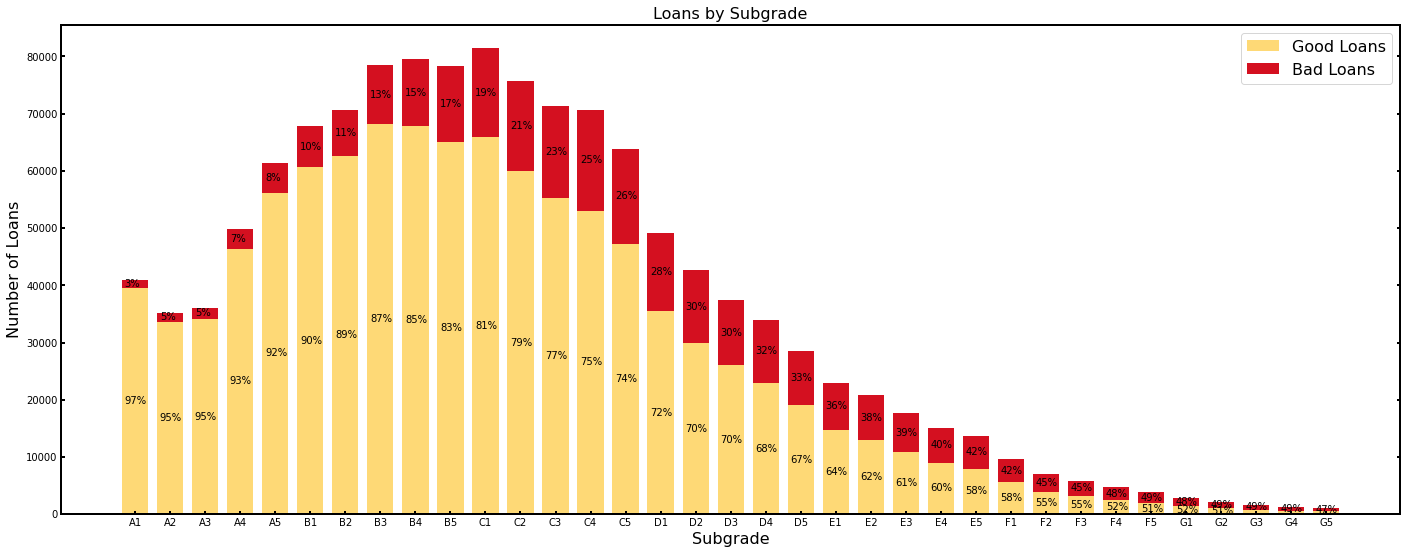

In [74]:
# Plot data
subgrade_labels = {
    "xlabel" : "Subgrade",
    "ylabel" : "Number of Loans",
    "title" : "Loans by Subgrade"
}

plot_stackedbar(data = subgrade_data, coltogroupby = "sub_grade", labels = subgrade_labels, x_loc = 0.08, y_loc = 0.5e3, labelrotation = 0, size = (24, 9), sigfigs = 0, annot_fontsize = 10)

In [75]:
subgrade_data_df = subgrade_data['df']

The correlation between both factors is 0.99
r-square is: 0.9917850359904278


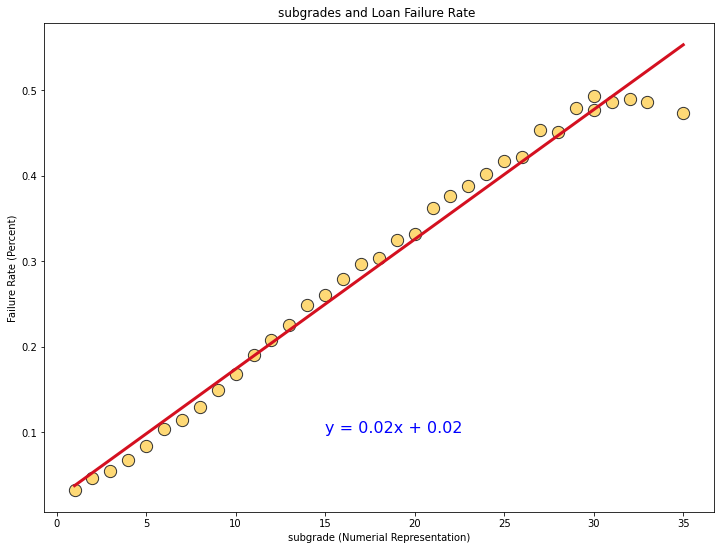

In [76]:
lst = [subgrade_data_df]
subgrade_data_df['sub_int'] = np.nan

for col in lst:
    col.loc[col['sub_grade']=='A1', 'sub_int'] = 1
    col.loc[col['sub_grade']=='A2', 'sub_int'] = 2
    col.loc[col['sub_grade']=='A3', 'sub_int'] = 3
    col.loc[col['sub_grade']=='A4', 'sub_int'] = 4
    col.loc[col['sub_grade']=='A5', 'sub_int'] = 5
    col.loc[col['sub_grade']=='B1', 'sub_int'] = 6
    col.loc[col['sub_grade']=='B2', 'sub_int'] = 7
    col.loc[col['sub_grade']=='B3', 'sub_int'] = 8
    col.loc[col['sub_grade']=='B4', 'sub_int'] = 9
    col.loc[col['sub_grade']=='B5', 'sub_int'] = 10
    col.loc[col['sub_grade']=='C1', 'sub_int'] = 11
    col.loc[col['sub_grade']=='C2', 'sub_int'] = 12
    col.loc[col['sub_grade']=='C3', 'sub_int'] = 13
    col.loc[col['sub_grade']=='C4', 'sub_int'] = 14
    col.loc[col['sub_grade']=='C5', 'sub_int'] = 15
    col.loc[col['sub_grade']=='D1', 'sub_int'] = 16
    col.loc[col['sub_grade']=='D2', 'sub_int'] = 17
    col.loc[col['sub_grade']=='D3', 'sub_int'] = 18
    col.loc[col['sub_grade']=='D4', 'sub_int'] = 19
    col.loc[col['sub_grade']=='D5', 'sub_int'] = 20
    col.loc[col['sub_grade']=='E1', 'sub_int'] = 21
    col.loc[col['sub_grade']=='E2', 'sub_int'] = 22
    col.loc[col['sub_grade']=='E3', 'sub_int'] = 23
    col.loc[col['sub_grade']=='E4', 'sub_int'] = 24
    col.loc[col['sub_grade']=='E5', 'sub_int'] = 25
    col.loc[col['sub_grade']=='F1', 'sub_int'] = 26
    col.loc[col['sub_grade']=='F2', 'sub_int'] = 27
    col.loc[col['sub_grade']=='F3', 'sub_int'] = 28
    col.loc[col['sub_grade']=='F4', 'sub_int'] = 29
    col.loc[col['sub_grade']=='F5', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G1', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G2', 'sub_int'] = 31
    col.loc[col['sub_grade']=='G3', 'sub_int'] = 32
    col.loc[col['sub_grade']=='G4', 'sub_int'] = 33
    col.loc[col['sub_grade']=='G5', 'sub_int'] = 35 

    
x = subgrade_data_df["sub_int"]
y = subgrade_data_df["bad_percentage"]
xlab = "subgrade (Numerial Representation)"
ylab = "Failure Rate (Percent)"
title = "subgrades and Loan Failure Rate "
an_x = 15
an_y = .1
    
lr_only(x, y, xlab, ylab, title, an_x, an_y)

In [77]:
grade_data_df = grade_data['df']

lst = [grade_data_df]

grade_data['grade_int'] = np.nan


for col in lst:
    col.loc[col['grade'] == 'A', "grade_int"] = 1
    col.loc[col['grade'] == 'B', "grade_int"] = 2
    col.loc[col['grade'] == 'C', "grade_int"] = 3
    col.loc[col['grade'] == 'D', "grade_int"] = 4
    col.loc[col['grade'] == 'E', "grade_int"] = 5
    col.loc[col['grade'] == 'F', "grade_int"] = 6
    col.loc[col['grade'] == 'G', "grade_int"] = 7
    
grade_data_df

,grade,bad_count,bad_percentage,good_count,good_percentage,grade_int
0,A,13485,0.060375,209868,0.939625,1.0
1,B,50269,0.134115,324552,0.865885,2.0
2,C,81484,0.224446,281561,0.775554,3.0
3,D,58243,0.303792,133477,0.696208,4.0
4,E,34786,0.385342,55487,0.614658,5.0
5,F,14054,0.452086,17033,0.547914,6.0
6,G,4390,0.496382,4454,0.503618,7.0


The correlation between both factors is 1.0
r-square is: 0.9964153052569049


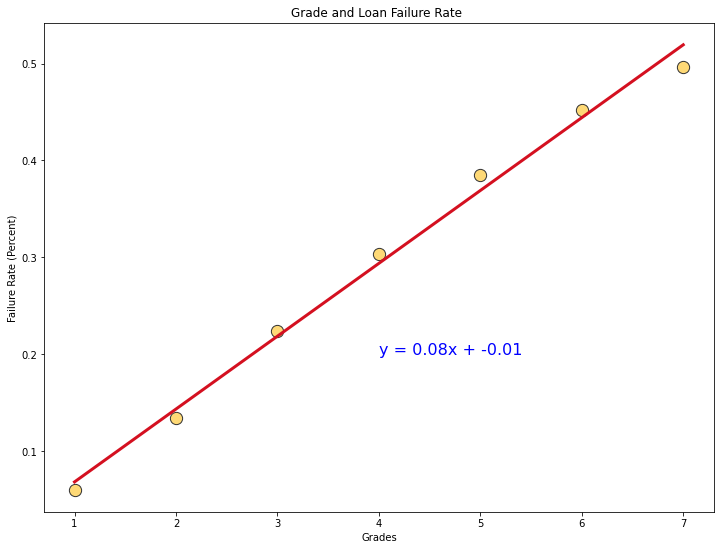

In [78]:
x = grade_data_df["grade_int"]
y = grade_data_df["bad_percentage"]
xlab = "Grades"
ylab = "Failure Rate (Percent)"
title = "Grade and Loan Failure Rate "
an_x = 4
an_y = .20
    
lr_only(x, y, xlab, ylab, title, an_x, an_y)

# MODELING PRE-PROCESSING

In [79]:
df.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util',
       'num_sats', 'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade'],
      dtype='object')

In [80]:
df['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

In [81]:
#required

lst = [df]
df['sub_int'] = np.nan

for col in lst:
    col.loc[col['sub_grade']=='A1', 'sub_int'] = 1
    col.loc[col['sub_grade']=='A2', 'sub_int'] = 2
    col.loc[col['sub_grade']=='A3', 'sub_int'] = 3
    col.loc[col['sub_grade']=='A4', 'sub_int'] = 4
    col.loc[col['sub_grade']=='A5', 'sub_int'] = 5
    col.loc[col['sub_grade']=='B1', 'sub_int'] = 6
    col.loc[col['sub_grade']=='B2', 'sub_int'] = 7
    col.loc[col['sub_grade']=='B3', 'sub_int'] = 8
    col.loc[col['sub_grade']=='B4', 'sub_int'] = 9
    col.loc[col['sub_grade']=='B5', 'sub_int'] = 10
    col.loc[col['sub_grade']=='C1', 'sub_int'] = 11
    col.loc[col['sub_grade']=='C2', 'sub_int'] = 12
    col.loc[col['sub_grade']=='C3', 'sub_int'] = 13
    col.loc[col['sub_grade']=='C4', 'sub_int'] = 14
    col.loc[col['sub_grade']=='C5', 'sub_int'] = 15
    col.loc[col['sub_grade']=='D1', 'sub_int'] = 16
    col.loc[col['sub_grade']=='D2', 'sub_int'] = 17
    col.loc[col['sub_grade']=='D3', 'sub_int'] = 18
    col.loc[col['sub_grade']=='D4', 'sub_int'] = 19
    col.loc[col['sub_grade']=='D5', 'sub_int'] = 20
    col.loc[col['sub_grade']=='E1', 'sub_int'] = 21
    col.loc[col['sub_grade']=='E2', 'sub_int'] = 22
    col.loc[col['sub_grade']=='E3', 'sub_int'] = 23
    col.loc[col['sub_grade']=='E4', 'sub_int'] = 24
    col.loc[col['sub_grade']=='E5', 'sub_int'] = 25
    col.loc[col['sub_grade']=='F1', 'sub_int'] = 26
    col.loc[col['sub_grade']=='F2', 'sub_int'] = 27
    col.loc[col['sub_grade']=='F3', 'sub_int'] = 28
    col.loc[col['sub_grade']=='F4', 'sub_int'] = 29
    col.loc[col['sub_grade']=='F5', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G1', 'sub_int'] = 30
    col.loc[col['sub_grade']=='G2', 'sub_int'] = 31
    col.loc[col['sub_grade']=='G3', 'sub_int'] = 32
    col.loc[col['sub_grade']=='G4', 'sub_int'] = 33
    col.loc[col['sub_grade']=='G5', 'sub_int'] = 35 


In [82]:
df['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

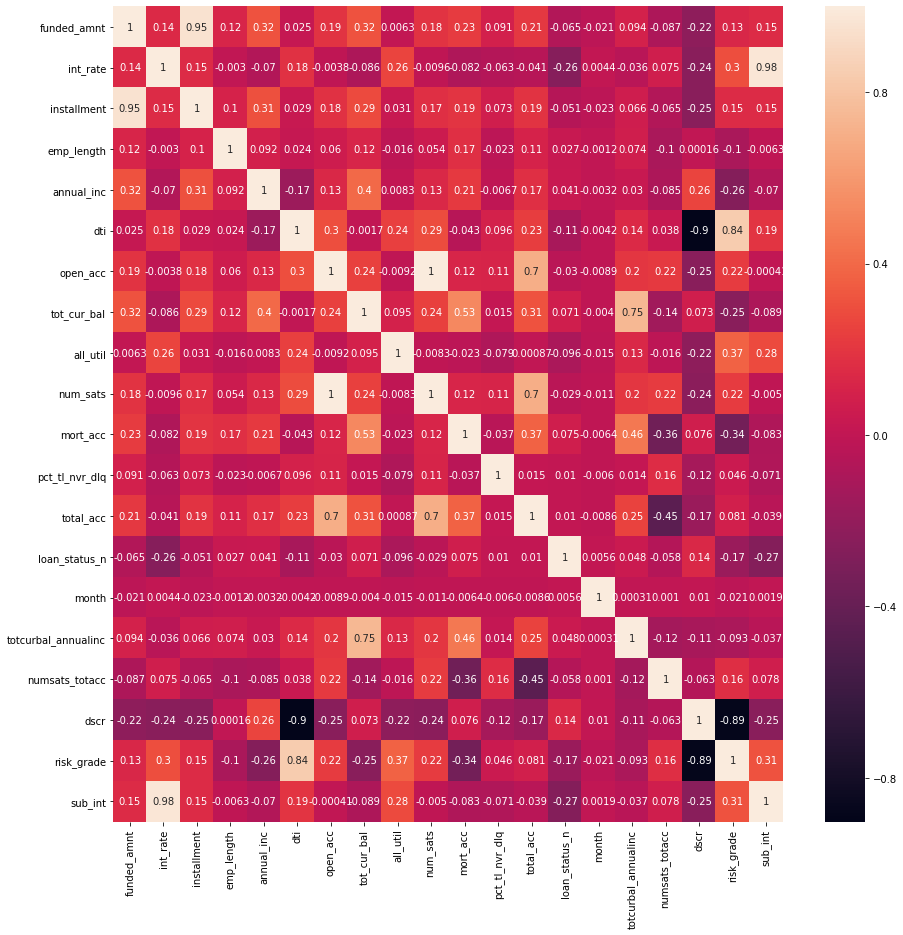

In [83]:
cor = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cor, annot=True)

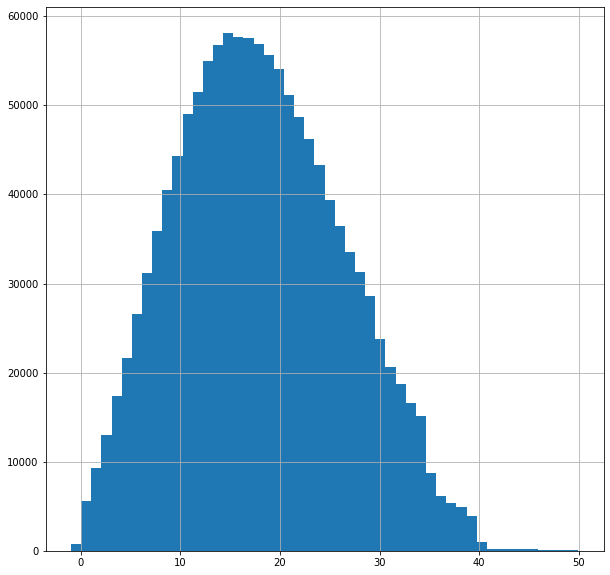

In [84]:
df['dti'].hist(bins=50,figsize=(10,10))

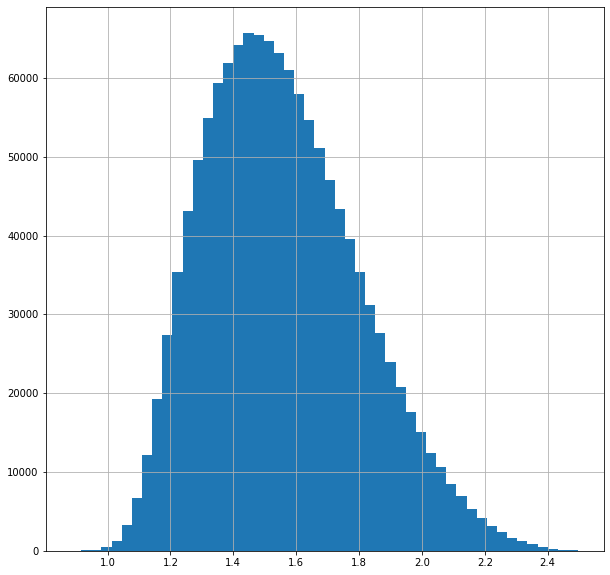

In [85]:
df['dscr'].hist(bins=50,figsize=(10,10))

In [86]:
#Loans that are bad
#Loans that are good

In [87]:
good_sample = df[(df.loan_status == "Good")]

In [88]:
bad_sample =  df[(df.loan_status == "Bad")]

In [89]:
#good_sample = good_sample.sample(250000)
#bad_sample = bad_sample.sample(250000)

In [90]:
#adjustment to compensate for imbalance (appending method)
bad_adjusted = bad_sample.append([bad_sample]*3)

In [91]:
combined_sample = good_sample.append(bad_adjusted)

In [92]:
combined_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util',
       'num_sats', 'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int'],
      dtype='object')

In [93]:
combined_sample['loan_status'].value_counts()

Bad     1026844
Good    1026432
Name: loan_status, dtype: int64

In [94]:
cat_var = ['sub_grade']

In [95]:
unbalanced_sample = pd.get_dummies(df, columns=cat_var)

In [96]:
combined_sample = pd.get_dummies(combined_sample, columns=cat_var)

In [97]:
combined_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [98]:
# subgrades = ['sub_grade_A1','sub_grade_A2','sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 
#              'sub_grade_B1','sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
#              'sub_grade_C1','sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4','sub_grade_C5',
#              'sub_grade_D1','sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
#              'sub_grade_E1','sub_grade_E2','sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5',
#              'sub_grade_F1','sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
#              'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4','sub_grade_G5']

In [99]:
combined_sample.head()

,funded_amnt,term,int_rate,installment,grade,application_type,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,open_acc,tot_cur_bal,all_util,num_sats,mort_acc,pct_tl_nvr_dlq,total_acc,last_pymnt_d,loan_status_n,month,totcurbal_annualinc,numsats_totacc,dscr,risk_grade,sub_int,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
186,4500,36 months,11.31,147.99,B,Individual,10,RENT,38500.0,Not Verified,2018-12-01,Good,credit_card,TX,4.64,12.0,29137.0,54.0,12.0,0.0,91.7,25.0,Feb-2019,1,12,0.756805,0.480000,2.030347,0.184788,8.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,20000,60 months,17.97,507.55,D,Individual,4,RENT,57000.0,Not Verified,2018-12-01,Good,debt_consolidation,WA,22.18,10.0,33356.0,46.0,10.0,1.0,100.0,16.0,Jan-2019,1,12,0.585193,0.625000,1.372396,0.205372,16.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271,6600,36 months,11.31,217.05,B,Individual,10,RENT,45000.0,Not Verified,2018-12-01,Good,credit_card,TX,16.21,6.0,26836.0,70.0,6.0,0.0,84.6,13.0,Jan-2019,1,12,0.596356,0.461538,1.612955,0.196108,8.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,2500,36 months,13.56,84.92,C,Individual,5,RENT,42000.0,Not Verified,2018-12-01,Good,other,PA,15.09,3.0,18649.0,57.0,3.0,0.0,83.3,6.0,Jan-2019,1,12,0.444024,0.500000,1.738638,0.195203,11.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369,4000,36 months,17.97,144.55,D,Individual,5,MORTGAGE,60000.0,Source Verified,2018-12-01,Good,house,TX,19.10,11.0,106556.0,72.0,11.0,2.0,88.2,18.0,Feb-2019,1,12,1.775933,0.611111,1.613137,0.193875,16.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# LOAN MODELING AND PREDICTION
Based on our classfication of good and bad loans, can we train a logistics model to anaylyze the metrics and determine a good and/or bad loan?

# --- FIRST FUNCTIONS THAT WILL BE APPLIED FOR EACH MODEL --

# Function to print Confustion Matrix

In [100]:
import itertools

In [101]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(5.5,4))
    xticks = ['Bad Loans', 'Good Loans']
    yticks = ['Bad Loans', 'Good Loans']
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cnf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cnf_matrix.flatten()/np.sum(cnf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    categories = ['Bad Loan','Positive']
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Reds', xticklabels=xticks, yticklabels=yticks)
    plt.xlabel('Predicated Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     plt.yticks(tick_marks, classes)
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()


# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=['Negative','Positive'],
#                       title='Confusion matrix, without normalization')

In [102]:
# plot_confusion_matrix(cnf_matrix, classes=['Negative','Positive'],
#                       title='Confusion matrix, without normalization')

# Function to Print Stats

In [103]:
def plot_confusion_stats(y_test,y_pred):
    #extracting true_positives (GOOD LOAN/GOODLOAN), false_positives(BAD LOAN/GOOD LOAN), true_negatives (BAD/BAD), false_negatives (GOOD/BAD)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total = tn+fp+fn+tp
    print("True Negatives: ",tn, (tn/total)*100)
    print("False Positives: ",fp, (fp/total)*100)
    print("False Negatives: ",fn, (fn/total)*100)
    print("True Positives: ",tp, (tp/total)*100)
    
    #Accuracy
    Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
    print(f"Accuracy {Accuracy}")
    
    #Precision 
    # Too low for the industry, we have to try to minimize the False Positives. This measure is important. We want close to 1.00.
    # We cacluate the ratio of true positive over the entire sets of true positive and false positives

    Precision = tp/(tp+fp) 
    print("Precision {:0.2f}".format(Precision))
    
    #Recall 
    # relates to false negatives. The raw count is good so this should correlate.
    # we calcculate the tratio of true positives over the entire sets of true positives and false negatives
    Recall = tp/(tp+fn) 
    print("Recall {:0.2f}".format(Recall))
    
    #F1 Score
    # ranges from 0 to 1. F1 Score reaches its best value at 1 (perfect precision & recall) and worst at 0,
    f1 = (2*Precision*Recall)/(Precision + Recall)
    print("F1 Score {:0.2f}".format(f1))
    
    #Specificity 
    #True Negative Rate (Prportion of actual negaties that are correctly identified)
    Specificity = tn/(tn+fp)
    print("Specificity {:0.2f}".format(Specificity))
    
  
    
    
    
    
    
    

In [104]:
# np.any(np.isnan(selected_features))

In [105]:
#np.all(np.isfinite(selected_features))

# MODEL 1
# LOGISTIC
# GOOD BAD LOAN VS DSCR BASIC
# Uses Jorge, sampled set
# Hot encoding sub_int


In [106]:
# Set features. This will also be used as your x values.
# x values will be the dscr calculated result, interest rate, amount funded, employment length
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'loan_status']]

In [107]:
selected_features['loan_status'].value_counts()

Bad     1026844
Good    1026432
Name: loan_status, dtype: int64

In [108]:
selected_features

,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,loan_status
186,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good
269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good
271,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good
296,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good
369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260633,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Bad
2260638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bad
2260640,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bad
2260654,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bad


In [109]:
# selected_features = selected_features.dropna()

In [110]:
X = selected_features.drop("loan_status", axis=1)
y = selected_features['loan_status']

In [111]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False)
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=0)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  615982
number of test samples:  1437294


In [113]:
model.fit(X_train,y_train)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [114]:
print(f"Training Accuracy: {model.score(X_train, y_train)*100}")
print(f"Testing Accuracy: {model.score(X_test, y_test)*100}")

Training Accuracy: 63.81826092320879
Testing Accuracy: 63.81825847738875


In [115]:
y_pred = model.predict(X_test)

In [116]:
results = pd.DataFrame({"Prediction":y_pred, "Actual":y_test}).reset_index(drop=True)
results['match'] = results['Prediction'] == results['Actual']
results.head()


,Prediction,Actual,match
0,Good,Bad,False
1,Good,Good,True
2,Bad,Bad,True
3,Bad,Bad,True
4,Bad,Bad,True


In [117]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

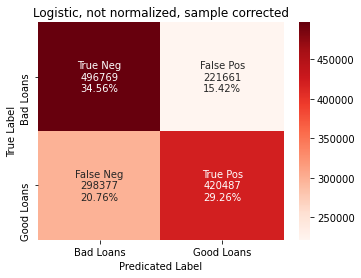

In [118]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='Logistic, not normalized, sample corrected')

In [119]:
plot_confusion_stats(y_test,y_pred)

True Negatives:  496769 34.56279647726909
False Positives:  221661 15.422105706974357
False Negatives:  298377 20.759635815636884
True Positives:  420487 29.25546200011967
Accuracy 63.81825847738876
Precision 0.65
Recall 0.58
F1 Score 0.62
Specificity 0.69


# Some data exploration for manual confusion matrix for verification

In [120]:
falseNegative = results.loc[(results["Prediction"] == "Bad") & (results["Actual"] == "Good")]
falsePositive = results.loc[(results["Prediction"] == "Good") & (results["Actual"] == "Bad")]
truepositive =  results.loc[(results["Prediction"] == "Good") & (results["Actual"] == "Good")]
truenegative = results.loc[(results["Prediction"] == "Bad") & (results["Actual"] == "Bad")]
truepositive.count()



Prediction    420487
Actual        420487
match         420487
dtype: int64

In [121]:
truenegative.count()

Prediction    496769
Actual        496769
match         496769
dtype: int64

In [122]:
falseNegative.count()

Prediction    298377
Actual        298377
match         298377
dtype: int64

In [123]:
falsePositive.count()

Prediction    221661
Actual        221661
match         221661
dtype: int64

# Each Measure Separate

In [124]:
#extracting true_positives (GOOD LOAN/GOODLOAN), false_positives(BAD LOAN/GOOD LOAN), true_negatives (BAD/BAD), false_negatives (GOOD/BAD)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
total = tn+fp+fn+tp
print("True Negatives: ",tn, (tn/total)*100)
print("False Positives: ",fp, (fp/total)*100)
print("False Negatives: ",fn, (fn/total)*100)
print("True Positives: ",tp, (tp/total)*100)



True Negatives:  496769 34.56279647726909
False Positives:  221661 15.422105706974357
False Negatives:  298377 20.759635815636884
True Positives:  420487 29.25546200011967


In [125]:
#Accuracy
Accuracy = (tn+tp)*100/(tp+tn+fp+fn) 
print(f"{Accuracy}")

63.81825847738876


In [126]:
#Precision 
# Too low for the industry, we have to try to minimize the False Positives. This measure is important. We want close to 1.00.
# We cacluate the ratio of true positive over the entire sets of true positive and false positives

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

Precision 0.65


In [127]:
#Recall 
# relates to false negatives. The raw count is good so this should correlate.
# we calcculate the tratio of true positives over the entire sets of true positives and false negatives
Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

Recall 0.58


In [128]:
#F1 Score
# ranges from 0 to 1. F1 Score reaches its best value at 1 (perfect precision & recall) and worst at 0,
f1 = (2*Precision*Recall)/(Precision + Recall)
print("F1 Score {:0.2f}".format(f1))

F1 Score 0.62


In [129]:
#Specificity 
#True Negative Rate (Prportion of actual negaties that are correctly identified)
Specificity = tn/(tn+fp)
print("Specificity {:0.2f}".format(Specificity))

Specificity 0.69


In [130]:
# Beta 0.5 & 2 are usually used as measures, 0.5 indicates the Inclination towards
#Precision whereas 2 favors Recall giving it twice the weightage compared to precision.
#F-beta score calculation
# def fbeta(precision, recall, beta):
#     return ((1+pow(beta,2))*precision*recall)/(pow(beta,2)*precision + recall)
            
# f2 = fbeta(Precision, Recall, 2)
# f0_5 = fbeta(Precision, Recall, 0.5)

# print("F2 {:0.2f}".format(f2))
# print("\nF0.5 {:0.2f}".format(f0_5))

In [131]:
#ROC (Receiver Operating Characteristic curve)
### conda install -c conda-forge scikit-plot



# import scikitplot as skplt #to make things easy
# y_pred_proba = model.predict_proba(X_test)
# skplt.metrics.plot_roc_curve(y_test, y_pred_proba)
# plt.show()

In [132]:
####

# OBSERVATION
#  Too many False Positives for a financial instituion. Investors(loaners) may invest in a loan marked as good and will turn out bad
# That means it predicted a loan that was bad as good
# Data is skewed (unbalanced) much more positives vs negatives to model
# Precision is  .80 - it's the ratio of TRUE POSITIVES over all true positives & false positives
# Recall is a measure of false negatives and it's ok @ 1.00. - It's a ratio of True Positives over all True positives and false negatives
# F1 @ .89 is not a perfect 1.00. It reflects the balance between Precision & Recall 
# Specificity is the True Negative Rate and it's very low at .01. The model has trouble pinpointing true negatives


In [133]:
####

# Decision Tree
# Decision Tree Attempted
# Poor Choice
# Scaling not necessary, hypertuning too early
# DecisionTreeClassifier not popular (try Random Forrest)
# Must deal with imbalance dataset

In [134]:
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5']]

In [135]:
labels = combined_sample[['loan_status']]

In [136]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.20, stratify=labels)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1642620
number of test samples:  410656


In [137]:
col_names_list = list(selected_features.columns.values)
print ("features in a list: ", col_names_list)
print ("\n")
print ("number of features: ", len(col_names_list))

features in a list:  ['sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']


number of features:  35


In [138]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [139]:
#randomforrest
#xgboost
#gradiantboostedtrees
#knn classifier
#svm
pipe_steps = [('scaler', StandardScaler()), ('decsT', DecisionTreeClassifier())]

check_params = {'decsT__criterion':['gini', 'entropy'], 
               'decsT__max_depth': np.arange(3, 15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('decsT',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=None, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=None,
                                        splitter='best'))],
         verbose=False)


In [140]:
from tqdm import tqdm_notebook as tqdm

In [141]:
# print ("start fitting the data")
# import warnings
# warnings.filterwarnings("ignore")


# for cv in tqdm(range(3, 6)):
#     create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
#     create_grid.fit(X_train, y_train)
#     print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))
#     print ("!!!! best fit parameters from GridSearchCV !!!!")
#     print (create_grid.best_params_)
    

# print ("out o' the loop")

In [142]:
# y_pred_tree = create_grid.predict(X_test)

# Random Forrest
# Append the bad loans to itself x3 to deal with imbalance
# independent is loan_status_n ; 1- good, 0 Bad
# hot encode the sub_grade

In [143]:
#df['loan_status_n'] = df['loan_status'].map({'Bad':1,'Good':0})
from sklearn import tree

In [144]:
combined_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [145]:
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5']]

In [146]:
target = combined_sample['loan_status_n']
target_names = ["Good", "Bad"]

In [147]:
combined_sample['loan_status_n'].count()

2053276

In [148]:
data = selected_features
feature_names = data.columns
data.head()

,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
186,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1539957
number of test samples:  513319


In [150]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6382931471463165

In [151]:
y_pred = rf.predict(X_test)

In [152]:
results = pd.DataFrame({"Prediction":y_pred, "Actual":y_test}).reset_index(drop=True)
results['match'] = results['Prediction'] == results['Actual']
results.head()

,Prediction,Actual,match
0,1,1,True
1,0,1,False
2,1,0,False
3,0,0,True
4,0,1,False


In [153]:
###

In [154]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)

<Figure size 432x288 with 0 Axes>

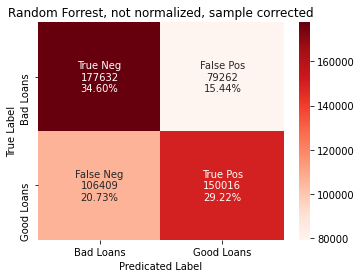

In [155]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='Random Forrest, not normalized, sample corrected')

In [156]:
plot_confusion_stats(y_test,y_pred)

True Negatives:  177632 34.60460259604651
False Positives:  79262 15.44108049770221
False Negatives:  106409 20.72960478766615
True Positives:  150016 29.224712118585128
Accuracy 63.82931471463164
Precision 0.65
Recall 0.59
F1 Score 0.62
Specificity 0.69


# XG Boost
# Same method as Random Forrest

In [157]:
#Verify Artificial Balance or use XG Boost Weight
#We'll start with artificial balancing
#both options are already hotencoded sub_grade
combined_sample['loan_status'].value_counts()

Bad     1026844
Good    1026432
Name: loan_status, dtype: int64

In [158]:
combined_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [159]:
unbalanced_sample['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

In [160]:
unbalanced_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [161]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [162]:
# define model
model = XGBClassifier()

In [163]:
selected_features = combined_sample[['sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5']]

In [164]:
selected_features.head()


,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
186,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
271,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [165]:
target = combined_sample['loan_status_n']

In [166]:
target.head()

186    1
269    1
271    1
296    1
369    1
Name: loan_status_n, dtype: int64

In [167]:
X,y = selected_features,target

In [168]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1642620
number of test samples:  410656


In [170]:
y_test.value_counts()

0    205754
1    204902
Name: loan_status_n, dtype: int64

In [171]:
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10) #scale_pos_weight' = sum_wneg/sum_wpos

In [172]:
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)

In [173]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.607726


In [174]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

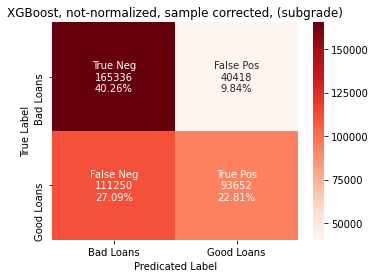

In [175]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not-normalized, sample corrected, (subgrade)')

In [176]:
plot_confusion_stats(y_test,y_pred)

True Negatives:  165336 40.26143536195745
False Positives:  40418 9.842301098729838
False Negatives:  111250 27.090801059767788
True Positives:  93652 22.805462479544925
Accuracy 63.066897841502374
Precision 0.70
Recall 0.46
F1 Score 0.55
Specificity 0.80


# XG Boost 2 (BALANCED RESULTS - DTI)

In [177]:
unbalanced_sample['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

In [178]:
unbalanced_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [179]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [180]:
# define model
model = XGBClassifier()

In [181]:

selected_features = unbalanced_sample[['dti']]
# selected_features = combined_sample[['dti', 'funded_amnt']]
#unbalanced_sample

In [182]:
selected_features.head()


,dti
186,4.64
269,22.18
271,16.21
296,15.09
369,19.10


In [183]:
target = unbalanced_sample['loan_status_n']
# target = combined_sample['loan_status_n']
#unbalanced_sample

In [184]:
target.head()

186    1
269    1
271    1
296    1
369    1
Name: loan_status_n, dtype: int64

In [185]:
X,y = selected_features,target

In [186]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1026514
number of test samples:  256629


In [188]:
y_train.value_counts()

1    821072
0    205442
Name: loan_status_n, dtype: int64

In [189]:
# scale_pos_weight [default=1]
# sum(negative instances) / sum(positive instances)
#Good 1026432
#Bad      256711
# scaled = 256711 / 1026432

In [190]:
#set  parameters for XGBClassifer
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, scale_pos_weight = .29, max_delta_step = 1)

In [191]:
xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

In [192]:
y_pred = xg_reg.predict(X_test)

In [193]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.575264


# Confusion Matrix

In [194]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

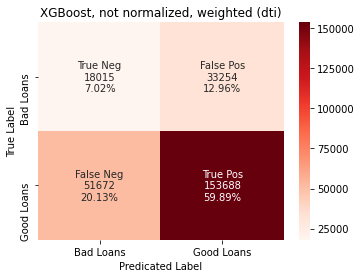

In [195]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not normalized, weighted (dti)')

In [196]:
plot_confusion_stats(y_test,y_pred)

True Negatives:  18015 7.0198613562769605
False Positives:  33254 12.958005525486207
False Negatives:  51672 20.134902914323792
True Positives:  153688 59.88723020391304
Accuracy 66.90709156019
Precision 0.82
Recall 0.75
F1 Score 0.78
Specificity 0.35


# Stratefied Kfold

In [197]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42)
skf

StratifiedKFold(n_splits=3, random_state=42, shuffle=False)

In [198]:
X.shape, y.shape

((1283143, 1), (1283143,))

In [199]:
skf.split(X,y)

<generator object _BaseKFold.split at 0x000001C589825848>

In [200]:
X.iloc[1965]


dti    25.7
Name: 91919, dtype: float64

In [201]:
# from sklearn.model_selection import cross_validate
# score=cross_validate(xg_reg,X,y,cv=10)

In [202]:
accuracy=[]
skf=StratifiedKFold(n_splits=5, random_state=None)
skf.get_n_splits(X,y)
#X is the featue set and y is the target
for train_index, test_index in skf.split(X,y):
    print("Train",train_index,"Validation:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
    
    xg_reg.fit(X1_train, y1_train)
    y1_pred = xg_reg.predict(X1_test)
    score=accuracy_score(y1_pred,y1_test)
    accuracy.append(score)
    
print(accuracy)
    

Train [ 221907  221910  221912 ... 1283140 1283141 1283142] Validation: [     0      1      2 ... 265601 265603 265604]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [221907 221910 221912 ... 524424 524425 524426]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [469015 469016 469030 ... 785718 785719 785720]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [ 717202  717206  717221 ... 1032795 1032796 1032797]
Train [      0       1       2 ... 1032795 1032796 1032797] Validation: [1000300 1000326 1000334 ... 1283140 1283141 1283142]
[0.6685500526049176, 0.6461272888099162, 0.6812195083934722, 0.6986922705238712, 0.6993780881275621]


In [203]:
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.548290


In [204]:
np.array(accuracy).mean()

0.6787934416919479

# Confusion Matrix  (Kfold Stratified)

In [205]:
cnf_matrix = confusion_matrix(y1_test, y1_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

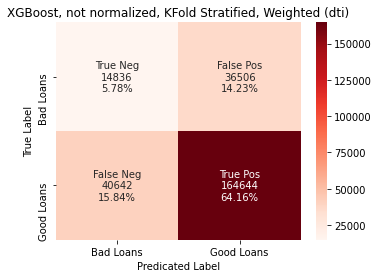

In [206]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not normalized, KFold Stratified, Weighted (dti)')

In [207]:
plot_confusion_stats(y1_test,y1_pred)

True Negatives:  14836 5.781130663840267
False Positives:  36506 14.225259909285034
False Negatives:  40642 15.836931277958758
True Positives:  164644 64.15667814891593
Accuracy 69.9378088127562
Precision 0.82
Recall 0.80
F1 Score 0.81
Specificity 0.29


# XG Boost 2 (CONSERVATIVE - SUB_INT)

In [208]:
unbalanced_sample['loan_status'].value_counts()

Good    1026432
Bad      256711
Name: loan_status, dtype: int64

In [209]:
unbalanced_sample.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'application_type', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'open_acc', 'tot_cur_bal', 'all_util', 'num_sats',
       'mort_acc', 'pct_tl_nvr_dlq', 'total_acc', 'last_pymnt_d',
       'loan_status_n', 'month', 'totcurbal_annualinc', 'numsats_totacc',
       'dscr', 'risk_grade', 'sub_int', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
      

In [210]:
#conda install -c anaconda py-xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

In [211]:
# define model
model = XGBClassifier()

In [212]:
selected_features = unbalanced_sample[['sub_int']]
# selected_features = unbalanced_sample[['dti']]
# selected_features = combined_sample[['dti', 'funded_amnt']]
#unbalanced_sample

In [213]:
selected_features.head()


,sub_int
186,8.0
269,16.0
271,8.0
296,11.0
369,16.0


In [214]:
target = unbalanced_sample['loan_status_n']
# target = combined_sample['loan_status_n']
#unbalanced_sample

In [215]:
target.head()

186    1
269    1
271    1
296    1
369    1
Name: loan_status_n, dtype: int64

In [216]:
X,y = selected_features,target

In [217]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [218]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print ("number of training samples: ", len(X_train))
print ("number of test samples: ", len(y_test))

number of training samples:  1026514
number of test samples:  256629


In [219]:
y_train.value_counts()

1    821072
0    205442
Name: loan_status_n, dtype: int64

In [220]:
# scale_pos_weight [default=1]
# sum(negative instances) / sum(positive instances)
#Good 1026432
#Bad      256711
# scaled = 256711 / 1026432

In [221]:
#set  parameters for XGBClassifer
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10, scale_pos_weight = .29, max_delta_step = 1)

In [222]:
xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=1, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.29, seed=None,
              silent=None, subsample=1, verbosity=1)

In [223]:
y_pred = xg_reg.predict(X_test)

In [224]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.599706


# Confusion Matrix

In [225]:
cnf_matrix = confusion_matrix(y_test, y_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

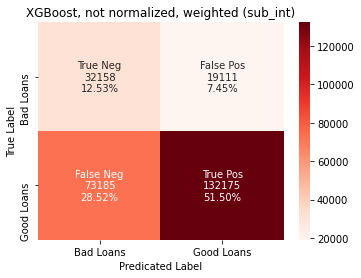

In [226]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not normalized, weighted (sub_int)')

In [227]:
plot_confusion_stats(y_test,y_pred)

True Negatives:  32158 12.530929863733247
False Positives:  19111 7.446937018029918
False Negatives:  73185 28.51782144652397
True Positives:  132175 51.50431167171286
Accuracy 64.0352415354461
Precision 0.87
Recall 0.64
F1 Score 0.74
Specificity 0.63


# Stratefied Kfold

In [228]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42)
skf

StratifiedKFold(n_splits=3, random_state=42, shuffle=False)

In [229]:
X.shape, y.shape

((1283143, 1), (1283143,))

In [230]:
skf.split(X,y)

<generator object _BaseKFold.split at 0x000001C59241FEC8>

In [231]:
X.iloc[1965]


sub_int    13.0
Name: 91919, dtype: float64

In [232]:
# from sklearn.model_selection import cross_validate
# score=cross_validate(xg_reg,X,y,cv=10)

In [233]:
accuracy=[]
skf=StratifiedKFold(n_splits=5, random_state=None)
skf.get_n_splits(X,y)
#X is the featue set and y is the target
for train_index, test_index in skf.split(X,y):
    print("Train",train_index,"Validation:", test_index)
    X1_train, X1_test = X.iloc[train_index], X.iloc[test_index]
    y1_train, y1_test = y.iloc[train_index], y.iloc[test_index]
    
    xg_reg.fit(X1_train, y1_train)
    y1_pred = xg_reg.predict(X1_test)
    score=accuracy_score(y1_pred,y1_test)
    accuracy.append(score)
    
print(accuracy)
    

Train [ 221907  221910  221912 ... 1283140 1283141 1283142] Validation: [     0      1      2 ... 265601 265603 265604]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [221907 221910 221912 ... 524424 524425 524426]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [469015 469016 469030 ... 785718 785719 785720]
Train [      0       1       2 ... 1283140 1283141 1283142] Validation: [ 717202  717206  717221 ... 1032795 1032796 1032797]
Train [      0       1       2 ... 1032795 1032796 1032797] Validation: [1000300 1000326 1000334 ... 1283140 1283141 1283142]
[0.6534777695514944, 0.6893180427777064, 0.6366140873170504, 0.6619971320354755, 0.621241641597955]


In [234]:
rmse = np.sqrt(mean_squared_error(y1_test, y1_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.615433


In [235]:
np.array(accuracy).mean()

0.6525297346559363

# Confusion Matrix  (Kfold Stratified)

In [236]:
cnf_matrix = confusion_matrix(y1_test, y1_pred)#y_pred_tree
np.set_printoptions(precision=2)


<Figure size 432x288 with 0 Axes>

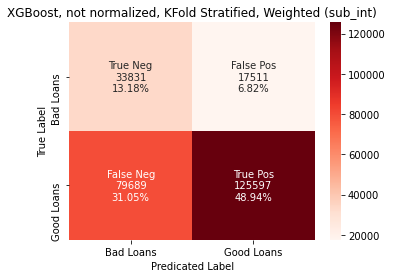

In [237]:
plt.figure()
plot_confusion_matrix(cnf_matrix, title='XGBoost, not normalized, KFold Stratified, Weighted (sub_int)')

In [238]:
plot_confusion_stats(y1_test,y1_pred)

True Negatives:  33831 13.1828950854934
False Positives:  17511 6.823495487631903
False Negatives:  79689 31.052340352572593
True Positives:  125597 48.9412690743021
Accuracy 62.1241641597955
Precision 0.88
Recall 0.61
F1 Score 0.72
Specificity 0.66


# Loan Forcasting Model
## overview
<ul>
<li>Model Identification. Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
<li>Parameter Estimation. Use a fitting procedure to find the coefficients of the regression model.
<li>Model Checking. Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.
</ul>

# Data Preparation

In [239]:
df.head()

,funded_amnt,term,int_rate,installment,grade,application_type,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,open_acc,tot_cur_bal,all_util,num_sats,mort_acc,pct_tl_nvr_dlq,total_acc,last_pymnt_d,loan_status_n,month,totcurbal_annualinc,numsats_totacc,dscr,risk_grade,sub_int
186,4500,36 months,11.31,147.99,B,Individual,B3,10,RENT,38500.0,Not Verified,2018-12-01,Good,credit_card,TX,4.64,12.0,29137.0,54.0,12.0,0.0,91.7,25.0,Feb-2019,1,12,0.756805,0.480000,2.030347,0.184788,8.0
269,20000,60 months,17.97,507.55,D,Individual,D1,4,RENT,57000.0,Not Verified,2018-12-01,Good,debt_consolidation,WA,22.18,10.0,33356.0,46.0,10.0,1.0,100.0,16.0,Jan-2019,1,12,0.585193,0.625000,1.372396,0.205372,16.0
271,6600,36 months,11.31,217.05,B,Individual,B3,10,RENT,45000.0,Not Verified,2018-12-01,Good,credit_card,TX,16.21,6.0,26836.0,70.0,6.0,0.0,84.6,13.0,Jan-2019,1,12,0.596356,0.461538,1.612955,0.196108,8.0
296,2500,36 months,13.56,84.92,C,Individual,C1,5,RENT,42000.0,Not Verified,2018-12-01,Good,other,PA,15.09,3.0,18649.0,57.0,3.0,0.0,83.3,6.0,Jan-2019,1,12,0.444024,0.500000,1.738638,0.195203,11.0
369,4000,36 months,17.97,144.55,D,Individual,D1,5,MORTGAGE,60000.0,Source Verified,2018-12-01,Good,house,TX,19.10,11.0,106556.0,72.0,11.0,2.0,88.2,18.0,Feb-2019,1,12,1.775933,0.611111,1.613137,0.193875,16.0


In [240]:
#sort dates by dates in ascending order, inplace is true
df.sort_values(by=['issue_d'], inplace=True, ascending=True)

In [241]:
#Get teh columns we want to look at: the funded amount, the issue_d (date) and teh month extrapolation of the date I created
#the month extrapolation may not be necessary
forecast_df = df[['funded_amnt','issue_d']]

In [242]:
#Group by the issue date, aggregate the laons for each month and calculate teh mean for that month
forecast_df = df.groupby('issue_d').agg({'funded_amnt': ['mean']})

In [243]:

forecast_df = forecast_df.reset_index()

In [244]:
#set date as index, makes plotting and forecasting easier

forecast_df = forecast_df.set_index('issue_d')

In [245]:
#Running the first 5 rows of the dataset
forecast_df.head()

,funded_amnt
,mean
issue_d,
2007-06-01,3827.083333
2007-07-01,5271.428571
2007-08-01,6602.702703
2007-09-01,7036.792453
2007-10-01,6503.571429


# Plotting the Loan Amount Data

No distinguable patter appears aside from a an upward trend in the early years. Thereafter, the average loan amount leveled out in the outter years. 

Examing some of the years

IS there Seasonal Activity?

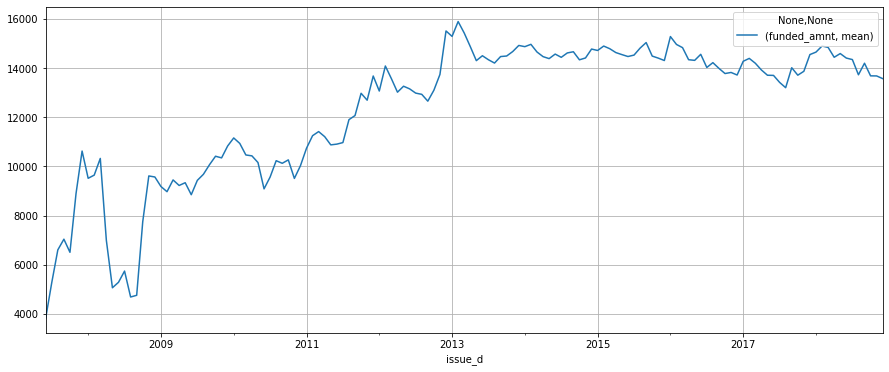

In [246]:
#data is plotted as a time series with month along the x-axis and loan figures(mean) on the 
forecast_df.plot(figsize=(15,6), grid=True)
plt.show()

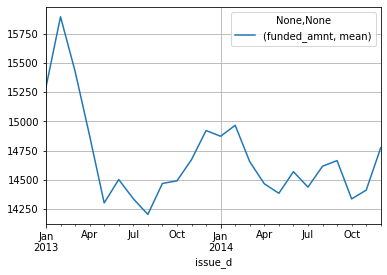

In [247]:
# ONE YEAR VIEW 2013-2014
from datetime import datetime
start_date = datetime(2013,1, 1)
end_date = datetime(2014, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

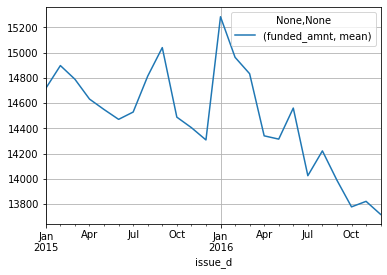

In [248]:
# ONE YEAR VIEW 2015-2016
from datetime import datetime
start_date = datetime(2015,1, 1)
end_date = datetime(2016, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

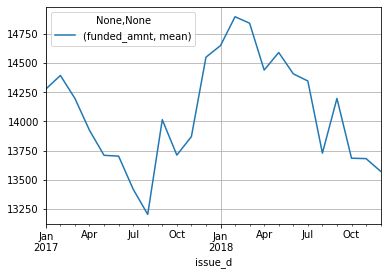

In [249]:
# ONE YEAR VIEW 2017-2018
from datetime import datetime
start_date = datetime(2017,1, 1)
end_date = datetime(2018, 12, 1)
forecast_df[(start_date <=forecast_df.index) & (forecast_df.index <= end_date)].plot(grid=True)

C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\ppage\Anaconda3\envs\TF\lib\site

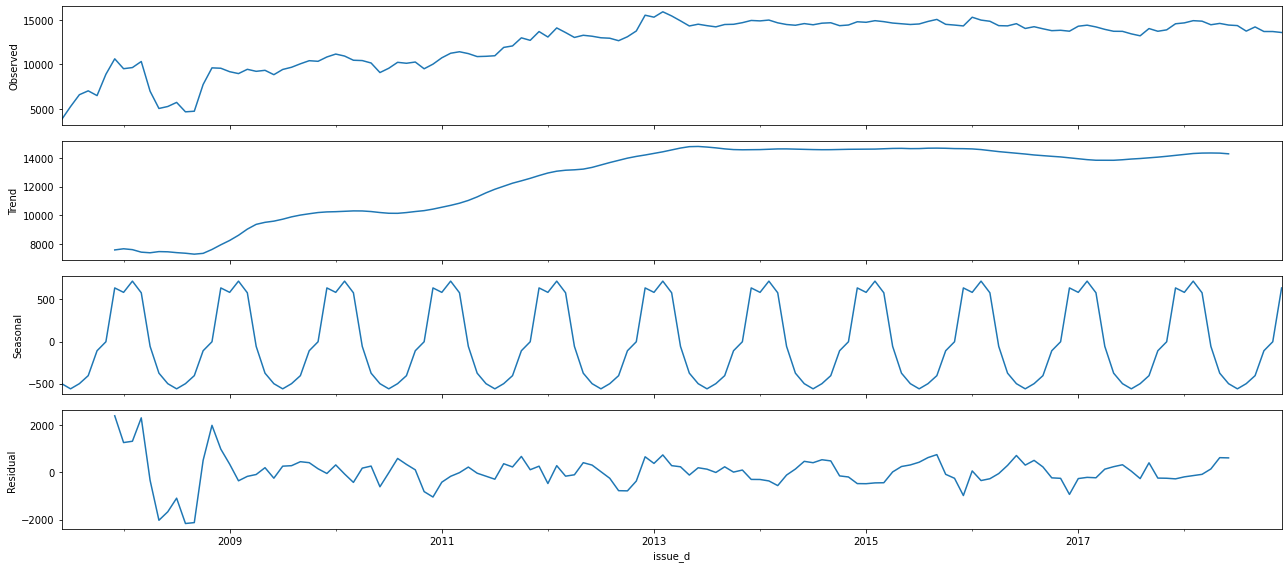

In [250]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(forecast_df, model='additive')
fig = decomposition.plot()
plt.show()


In [251]:
# import matplotlib.dates as mdates
# fig, ax = plt.subplots()
# ax.grid(True)
# year = mdates.YearLocator(month=1)
# month = mdates.MonthLocator(interval=3)
# year_format = mdates.DateFormatter('%Y')
# month_format = mdates.DateFormatter('%m')
# ax.xaxis.set_minor_locator(month)
# ax.xaxis.grid(True, which = 'minor')
# ax.xaxis.set_major_locator(year)
# ax.xaxis.set_major_formatter(year_format)
# plt.plot(forecast_df.index, forecast_df[('funded_amnt', 'mean')], c='blue')
# plt.plot(decomposition.trend.index, decomposition.trend, c='red')

In [252]:
# from pandas.plotting import autocorrelation_plot, lag_plot
# from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

# ARIMA MODEL
Autoregressive Integrated Moving Average

### ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [253]:

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


<h3>This step is parameter Selection for our  ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.</h3>
<P>
  <h3>The Akaike information criterion is an estimator of out-of-sample prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Choose the one withe lowest AIC</h3>
    <h3><i>Very Time Intensive, may not be necessary</i></h3>

In [254]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [255]:
#Fit ARIMA(5,1,0). This sets teh lag values to 5 for autoregression, uses a difference order of 1 to make the
#the time series stationary and uses a moving average model of 0.

from statsmodels.tsa.arima_model import ARIMA

 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = forecast_df
# fit model
model = ARIMA(series, order=(1,1,0))
model_fit = model.fit()
#disp=0 turns off debug information
print(model_fit.summary())


C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ppage\Anaconda3\envs\TF\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:     D.funded_amnt_mean   No. Observations:                  138
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1094.871
Method:                       css-mle   S.D. of innovations            675.070
Date:                Wed, 15 Jul 2020   AIC                           2195.742
Time:                        16:16:03   BIC                           2204.523
Sample:                    07-01-2007   HQIC                          2199.310
                         - 12-01-2018                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       72.2921     68.131      1.061      0.291     -61.242     205.826
ar.L1.D.funded_amnt_mean     0.1576      0.085      1.853      0.066      -0.009       0.

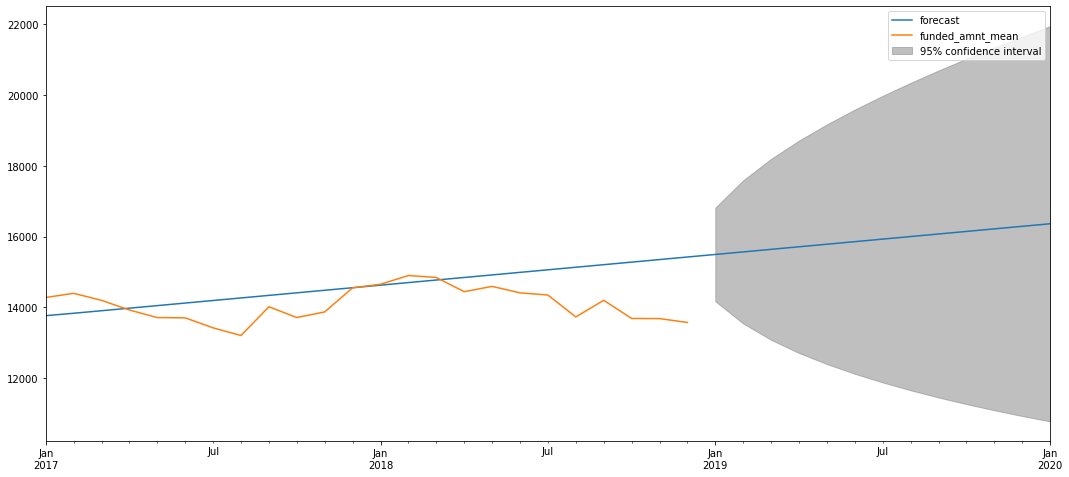

In [256]:
model_fit.plot_predict('2017', '2020', dynamic=True)
plt.show()

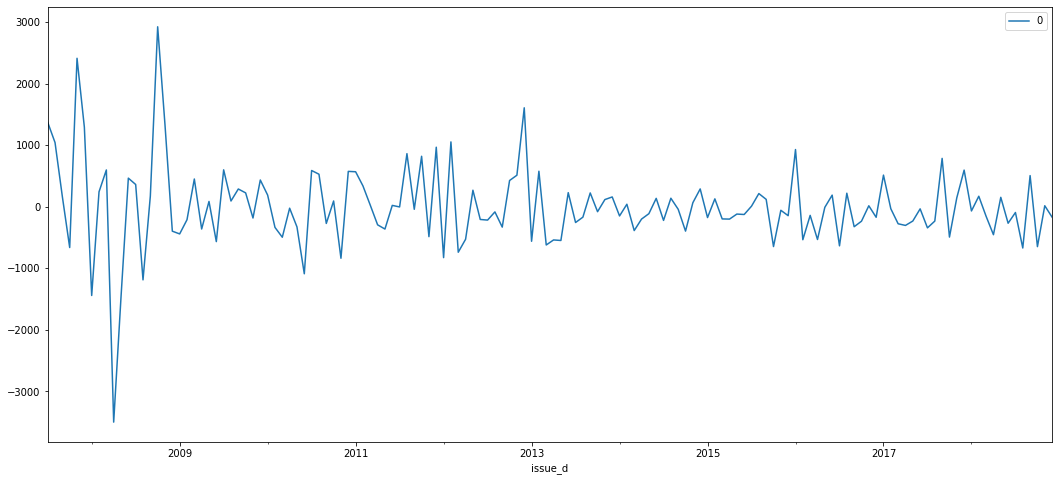

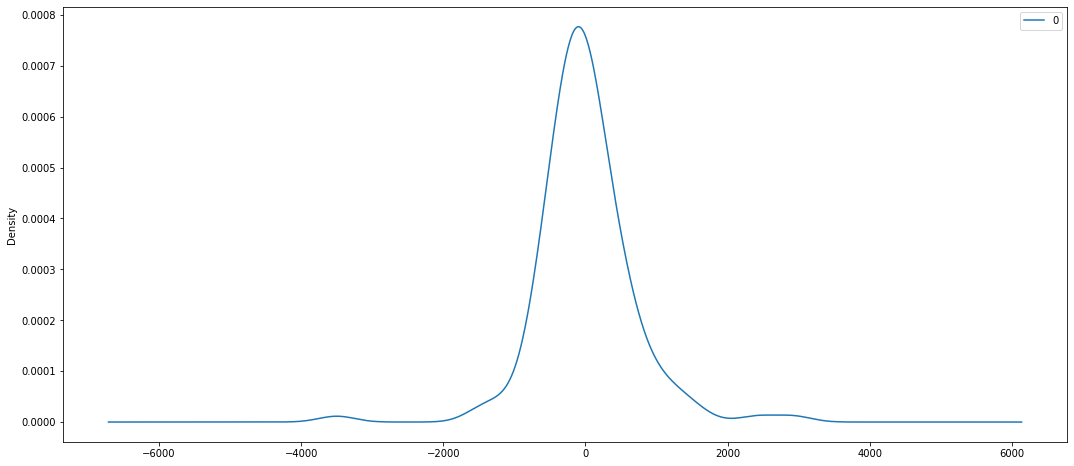

                 0
count   138.000000
mean     -1.619511
std     677.779542
min   -3499.025873
25%    -326.716175
50%     -49.241643
75%     228.086718
max    2923.896825


In [257]:
# plot residual errors
# Below summarizes the coefficient values used as well as the skill of teh fit on the on the in-sample observations
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


# PLOT 1  - First of residentuals suggest that there may be some trend information not captured by the model.
# PLOT 2 - The next plot is a density plot of the residual error values, is normally distributed (Gaussian). There is no skew.
# PLOT 2 OBSERVATION: The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

# Rolling Forecast ARIMA Model

Use the predict() function on teh ARIMAResults objec to make predictions. Accepts the index of the time steps to make
predictions as arguments

Running the example prints the prediction and expected value each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

Using the forecast() function, which performs a one-step forecast using the model.

In [258]:
series = forecast_df
X = forecast_df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

In [259]:
#Forecast and plot
result = pd.DataFrame({'training': test.ravel()[0:10], 'predictions': model_fit.forecast(10)[0]})


In [260]:
result.head()

,training,predictions
0,14716.776449,13615.727478
1,14896.735551,13683.522723
2,14788.370461,13755.106229
3,14631.579654,13827.286681
4,14548.878441,13899.561198


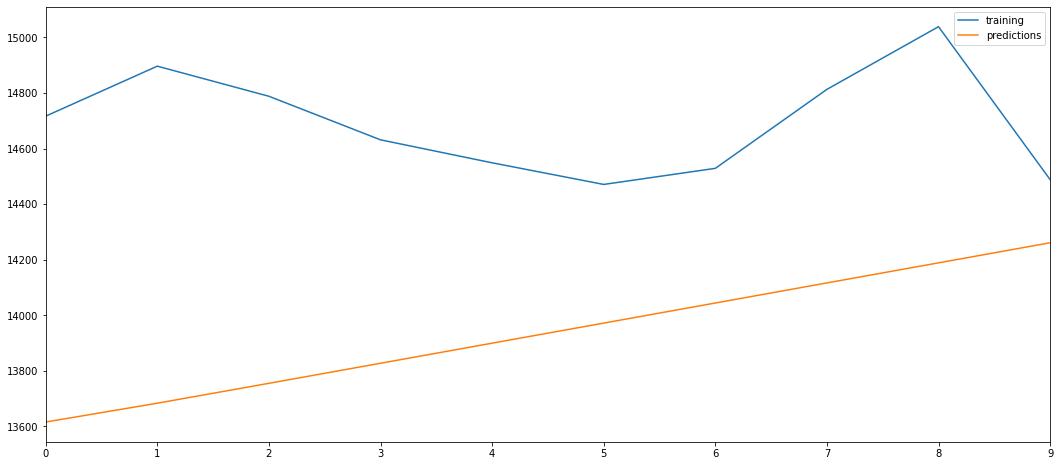

In [261]:
result.plot()

In [262]:
# from sklearn.metrics import mean_squared_error
 
# def parser(x):
# 	return datetime.strptime('190'+x, '%Y-%m')
 
# series = forecast_df
# X = forecast_df.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit(disp=0)
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(test, predictions)
# print('Test MSE: %.3f' % error)
# # plot
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()